In [1]:
# パッケージのimport
import numpy as np
import gym
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# 動画の描写
from JSAnimation.IPython_display import display_animation
from matplotlib import animation
from IPython.display import display


def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    plt.figure(figsize=(frames[0].shape[1]/72.0, frames[0].shape[0]/72.0),dpi=72)
    patch = plt.imshow(frames[0])
    plt.axis('off')
    
    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames=len(frames),interval=50)

    anim.save('movie_cartpole.mp4')  # 動画のファイル名と保存
    display(display_animation(anim, default_mode='loop'))

In [3]:
# 定数の設定
ENV = 'CartPole-v0'  # 使用する課題名
NUM_DIZITIZED = 6  # 各状態の離散値への分割数
GAMMA = 0.99  # 時間割引率
ETA = 0.5  # 学習係数
MAX_STEPS = 200  # 1試行のstep数
NUM_EPISODES =10000 # 最大試行回数

In [4]:
class Agent:
    '''CartPoleのエージェントクラス＝棒付き台車そのもの'''

    def __init__(self, num_states, num_actions):
        self.brain = Brain(num_states, num_actions)  # エージェントが行動を決定するための頭脳を生成

    def update_Q_function(self, observation, action, reward, observation_next):
        '''Q関数の更新'''
        self.brain.update_Q_table(observation, action, reward, observation_next)

    def get_action(self, observation, step):
        '''行動の決定'''
        action = self.brain.decide_action(observation, step)
        return action

In [5]:
class Brain:
    '''エージェントが持つ脳となるクラス。Q学習を実行する'''

    def __init__(self, num_states, num_actions):
        self.num_actions = num_actions  # CartPoleの行動（右に左に押す）の2を取得

        # Qテーブルを作成。行数は状態を分割数^（4変数）にデジタル変換した値、列数は行動数を示す
        self.q_table = np.random.uniform(low=0, high=1, size=(NUM_DIZITIZED**num_states, num_actions))


    def bins(self, clip_min, clip_max, num):
        '''観測した状態（連続値）を離散値にデジタル変換する閾値を求める'''
        return np.linspace(clip_min, clip_max, num + 1)[1:-1]

    def digitize_state(self, observation):
        '''観測したobservation状態を、離散値に変換する'''
        cart_pos, cart_v, pole_angle, pole_v = observation
        digitized = [
            np.digitize(cart_pos, bins=self.bins(-2.4, 2.4, NUM_DIZITIZED)),
            np.digitize(cart_v, bins=self.bins(-3.0, 3.0, NUM_DIZITIZED)),
            np.digitize(pole_angle, bins=self.bins(-0.5, 0.5, NUM_DIZITIZED)),
            np.digitize(pole_v, bins=self.bins(-2.0, 2.0, NUM_DIZITIZED))
        ]
        return sum([x * (NUM_DIZITIZED**i) for i, x in enumerate(digitized)])

    def update_Q_table(self, observation, action, reward, observation_next):
        '''QテーブルをQ学習により更新'''
        state = self.digitize_state(observation)  # 状態を離散化
        state_next = self.digitize_state(observation_next)  # 次の状態を離散化
        Max_Q_next = max(self.q_table[state_next][:])
        self.q_table[state, action] = self.q_table[state, action] + \
            ETA * (reward + GAMMA * Max_Q_next - self.q_table[state, action])

    def decide_action(self, observation, episode):
        '''ε-greedy法で徐々に最適行動のみを採用する'''
        state = self.digitize_state(observation)
        epsilon = 0.5 * (1 / (episode + 1))
        #epsilon = 0.5 * (0.99 ** episode)

        if epsilon <= np.random.uniform(0, 1):
            action = np.argmax(self.q_table[state][:])
        else:
            action = np.random.choice(self.num_actions)  # 0,1の行動をランダムに返す
        return action

In [6]:
class Environment:
    '''CartPoleを実行する環境のクラス'''

    def __init__(self):
        self.env = gym.make(ENV)  # 実行する課題を設定
        num_states = self.env.observation_space.shape[0]  # 課題の状態の数4を取得
        num_actions = self.env.action_space.n  # CartPoleの行動（右に左に押す）の2を取得
        self.agent = Agent(num_states, num_actions)  # 環境内で行動するAgentを生成

    def run(self):
        '''実行'''
        final_episode = False  # 最終試行フラグ
        goal_average_reward=195 #学習終了条件
        num_consecutive_iterations = 100  #学習完了評価に使用する平均試行回数
        total_reward_vec = np.zeros(num_consecutive_iterations)  #各試行の報酬を格納
        finished_step=[] #各試行の達成ステップ数を格納する変数
        episode_rewards=[] #各試行の総報酬を格納する変数
        reward_means=[] #平均報酬を格納を格納する変数
        frames = []  # 動画用に画像を格納する変数

        
        
        for episode in range(NUM_EPISODES):  # 試行数分繰り返す
            observation = self.env.reset()  # 環境の初期化
            episode_reward=0 #各試行の報酬の初期化

            for step in range(MAX_STEPS):  # 1エピソードのループ
                if  final_episode:
                    frames.append(self.env.render(mode='rgb_array'))
                    
                    
                # 行動を求める
                action = self.agent.get_action(observation, episode)

                # 行動a_tの実行により、s_{t+1}, r_{t+1}を求める
                observation_next, reward, done,_ = self.env.step(
                    action) # infoは使わないので_にする

                # 報酬を与える 
                if done:
                    if step<199:
                        reward = -200  # 途中でこけたら罰則として報酬-200を与える
                        
                episode_reward+=reward

                # step+1の状態observation_nextを用いて,Q関数を更新する
                self.agent.update_Q_function(
                    observation, action, reward, observation_next)

                # 観測の更新
                observation = observation_next

                # 終了時の処理
                if done:
                    total_reward_vec = np.hstack((total_reward_vec[1:], episode_reward))  #報酬を記録（直近100試行分）
                    print('{0} Episode: Finished after {1} time steps  Episode Reward:{2}/Mean:{3}'.format(
                        episode+1, step + 1,episode_reward,total_reward_vec.mean()))
                    finished_step.append(step+1) #達成ステップ数を格納
                    episode_rewards.append(episode_reward) #報酬を格納
                    reward_means.append(total_reward_vec.mean()) #平均報酬値を格納
                    break
                

            if final_episode:
                display_frames_as_gif(frames)
                break
                
            if  (total_reward_vec.mean() >= goal_average_reward) or ((episode+1)==NUM_EPISODES-1): 
                final_episode=True
                print('学習完了')
                
                #グラフの表示
                x=np.linspace(1,episode+1,episode+1)
                y1=finished_step
                y2=episode_rewards
                y3=reward_means
                width=((episode+1)/500)*6.4
                
                fig1=plt.figure(figsize=(width,4.8)) #達成ステップ数のグラフ画像
                ax1=fig1.add_subplot(111)
                ax1.plot(x,y1,lw=0.6)
                ax1.set_xlabel('episode')
                ax1.set_ylabel('max step')
                ax1.set_xlim(1,episode+1)
                ax1.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100)) #100試行ごとに目盛
                plt.grid(b=True, which='major',color='#999999', linestyle='-', alpha=0.4)
                
                fig2=plt.figure(figsize=(width,4.8)) #総報酬のグラフ画像
                ax2=fig2.add_subplot(111)
                ax2.plot(x,y2,lw=0.6)
                ax2.set_xlabel('episode')
                ax2.set_ylabel('episode reward')
                ax2.set_xlim(1,episode+1)
                ax2.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100)) #100試行ごとに目盛
                plt.grid(b=True, which='major',color='#999999', linestyle='-', alpha=0.4)


                fig3=plt.figure(figsize=(width,4.8)) #平均報酬のグラフ画像
                ax3=fig3.add_subplot(111)
                ax3.plot(x,y3,lw=0.6)
                ax3.set_xlabel('episode')
                ax3.set_ylabel('reward mean')
                ax3.set_xlim(1,episode+1)
                ax3.set_ylim(-120,200)
                ax3.xaxis.set_major_locator(mpl.ticker.MultipleLocator(100)) #100試行ごとに目盛
                plt.grid(b=True, which='major', color='#999999', linestyle='-', alpha=0.4)

C:\Users\hirot\Anaconda3\envs\rl_env\lib\site-packages\gym\envs\registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
1 Episode: Finished after 16 time steps  Episode Reward:-185.0/Mean:-1.85
2 Episode: Finished after 21 time steps  Episode Reward:-180.0/Mean:-3.65
3 Episode: Finished after 144 time steps  Episode Reward:-57.0/Mean:-4.22
4 Episode: Finished after 12 time steps  Episode Reward:-189.0/Mean:-6.11
5 Episode: Finished after 35 time steps  Episode Reward:-166.0/Mean:-7.77
6 Episode: Finished after 19 time steps  Episode Reward:-182.0/Mean:-9.59
7 Episode: Finished after 122 time steps  Episode Reward:-79.0/Mean:-10.38
8 Episode: Finished after 11 time steps  Episode Reward:-190.0/Mean:-12.28
9 Episode: Finished after 18 time steps  Episode Reward:-183.0/Mean:-14.11
10 Episode: Finished after 23 time steps  Episode Reward:-178.0/Mean:-15.89
11 Episode: Finished after 19 time steps  Episode Reward:-182.0/Mean:-17.71
12 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:-15.71
13 E

109 Episode: Finished after 145 time steps  Episode Reward:-56.0/Mean:-38.66
110 Episode: Finished after 186 time steps  Episode Reward:-15.0/Mean:-37.03
111 Episode: Finished after 171 time steps  Episode Reward:-30.0/Mean:-35.51
112 Episode: Finished after 13 time steps  Episode Reward:-188.0/Mean:-39.39
113 Episode: Finished after 173 time steps  Episode Reward:-28.0/Mean:-37.79
114 Episode: Finished after 15 time steps  Episode Reward:-186.0/Mean:-37.8
115 Episode: Finished after 17 time steps  Episode Reward:-184.0/Mean:-37.76
116 Episode: Finished after 193 time steps  Episode Reward:-8.0/Mean:-35.96
117 Episode: Finished after 147 time steps  Episode Reward:-54.0/Mean:-34.66
118 Episode: Finished after 147 time steps  Episode Reward:-54.0/Mean:-33.34
119 Episode: Finished after 171 time steps  Episode Reward:-30.0/Mean:-31.75
120 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:-27.86
121 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:-24.14
1

218 Episode: Finished after 142 time steps  Episode Reward:-59.0/Mean:118.91
219 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:121.21
220 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:121.21
221 Episode: Finished after 60 time steps  Episode Reward:-141.0/Mean:117.8
222 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:117.8
223 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:117.8
224 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:120.4
225 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:122.66
226 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:122.66
227 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:125.3
228 Episode: Finished after 141 time steps  Episode Reward:-60.0/Mean:125.38
229 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:125.38
230 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:125.38
231 

325 Episode: Finished after 129 time steps  Episode Reward:-72.0/Mean:94.02
326 Episode: Finished after 181 time steps  Episode Reward:-20.0/Mean:91.82
327 Episode: Finished after 163 time steps  Episode Reward:-38.0/Mean:89.44
328 Episode: Finished after 185 time steps  Episode Reward:-16.0/Mean:89.88
329 Episode: Finished after 173 time steps  Episode Reward:-28.0/Mean:87.6
330 Episode: Finished after 197 time steps  Episode Reward:-4.0/Mean:85.56
331 Episode: Finished after 167 time steps  Episode Reward:-34.0/Mean:85.65
332 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:85.65
333 Episode: Finished after 173 time steps  Episode Reward:-28.0/Mean:85.39
334 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:85.39
335 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:85.39
336 Episode: Finished after 145 time steps  Episode Reward:-56.0/Mean:82.83
337 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:82.83
338 Episode: F

435 Episode: Finished after 170 time steps  Episode Reward:-31.0/Mean:90.08
436 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:92.64
437 Episode: Finished after 195 time steps  Episode Reward:-6.0/Mean:90.58
438 Episode: Finished after 148 time steps  Episode Reward:-53.0/Mean:88.05
439 Episode: Finished after 178 time steps  Episode Reward:-23.0/Mean:85.82
440 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:88.65
441 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:91.38
442 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:93.79
443 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:96.43
444 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:98.96
445 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:98.96
446 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:101.24
447 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:101.24
448 Episode

544 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
545 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
546 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
547 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
548 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
549 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:109.09
550 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:112.66
551 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:112.66
552 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:112.66
553 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:112.66
554 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:112.66
555 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:115.1
556 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:117.3
5

652 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:144.53
653 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:144.53
654 Episode: Finished after 175 time steps  Episode Reward:-26.0/Mean:142.27
655 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
656 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
657 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
658 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
659 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
660 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
661 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
662 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
663 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27
664 Episode: Finished after 200 time steps  Episode Reward:200.0/Mean:142.27


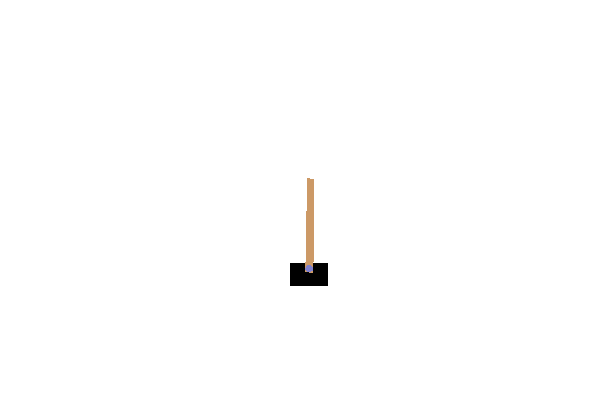
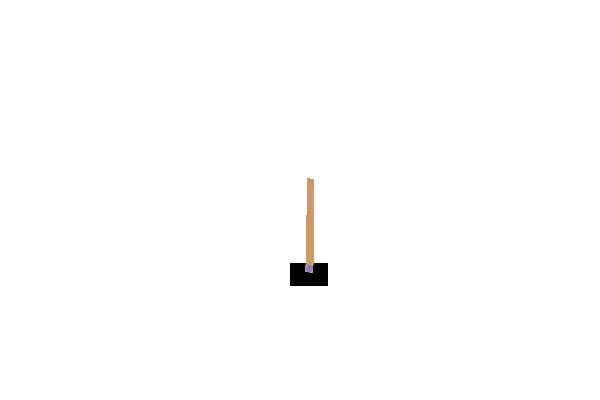
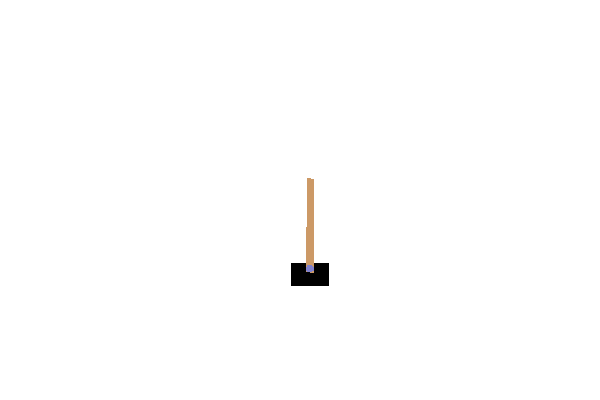
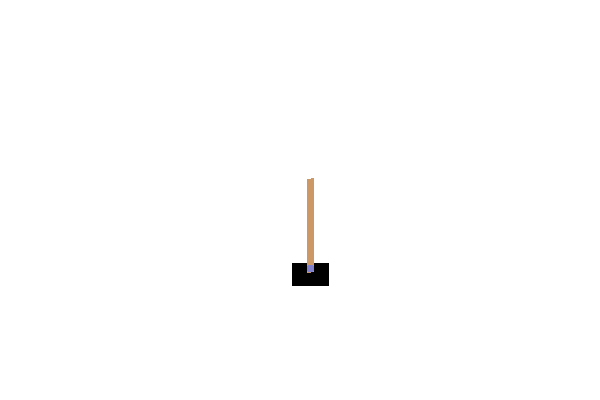
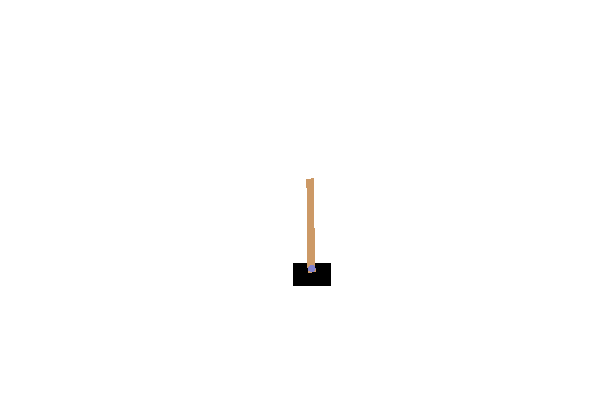
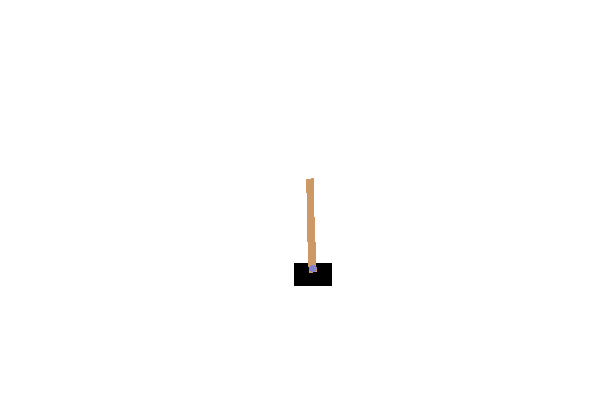
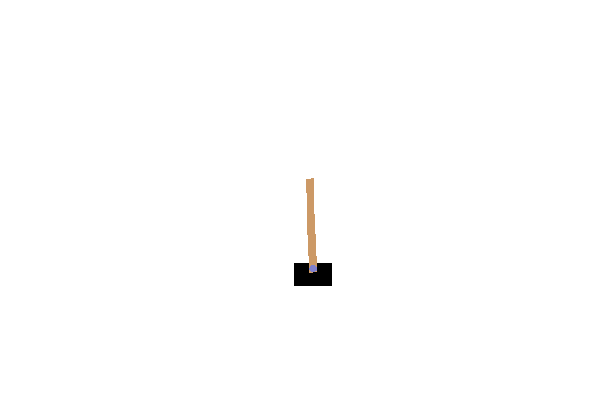
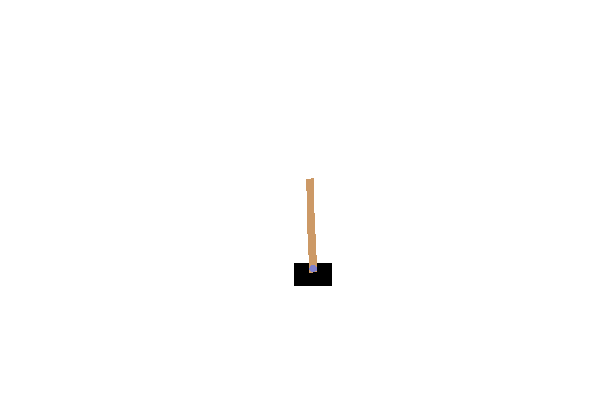
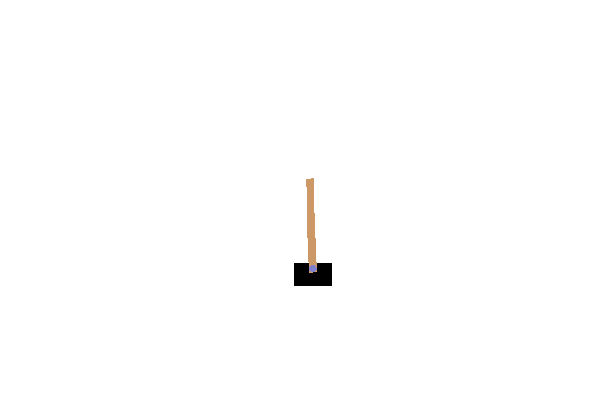
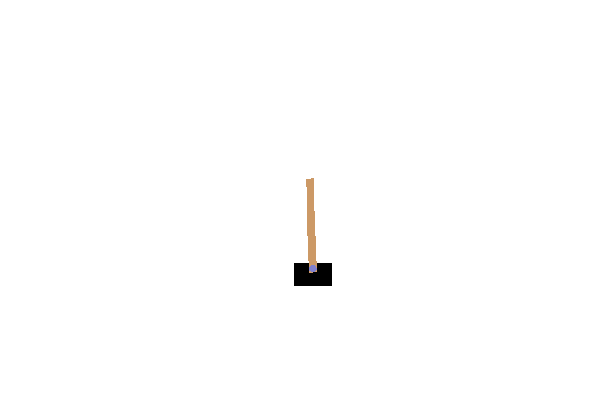
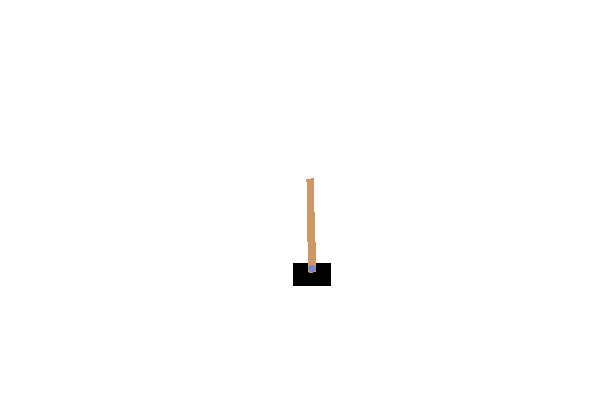
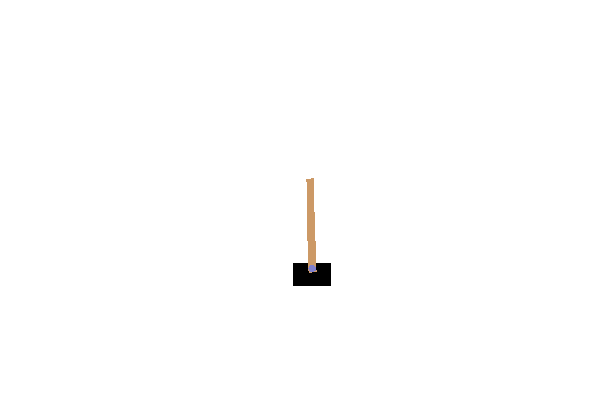
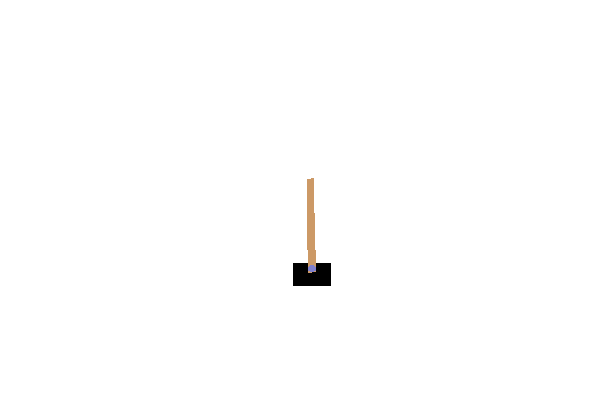
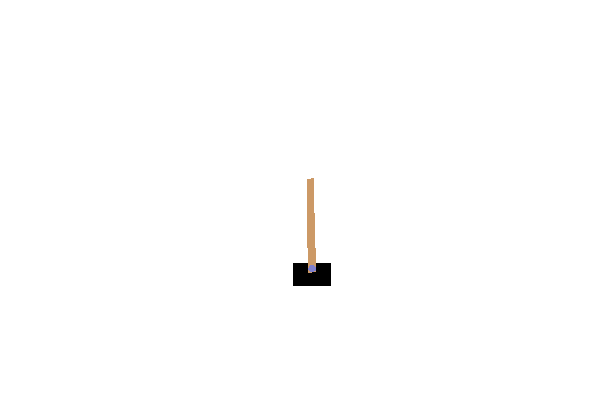
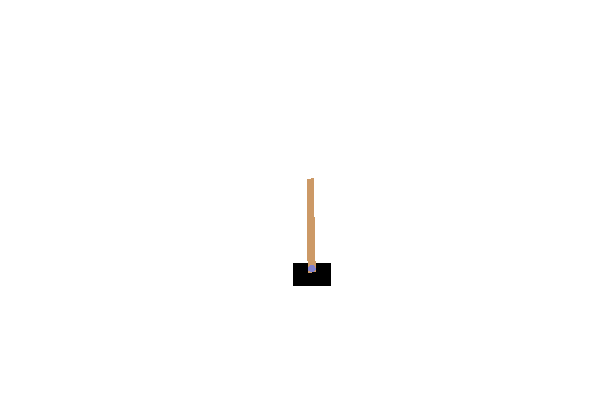
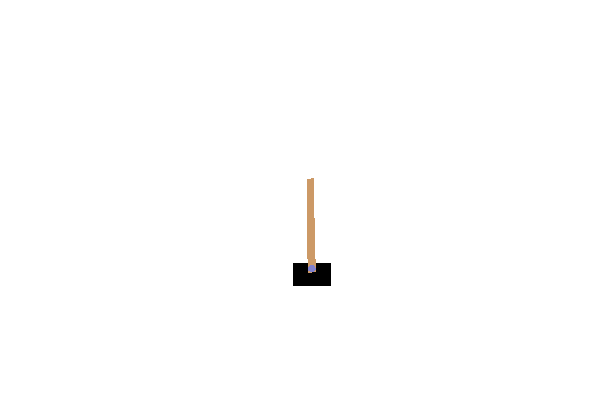
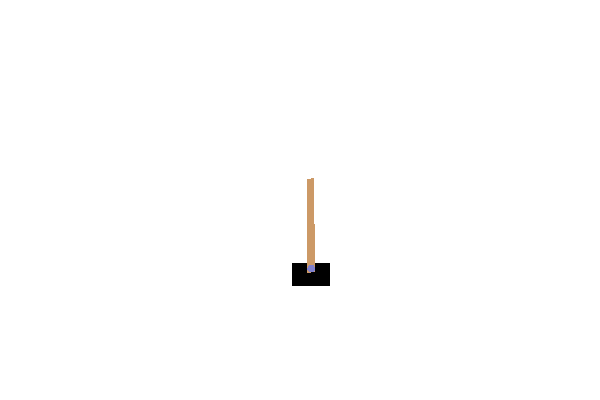
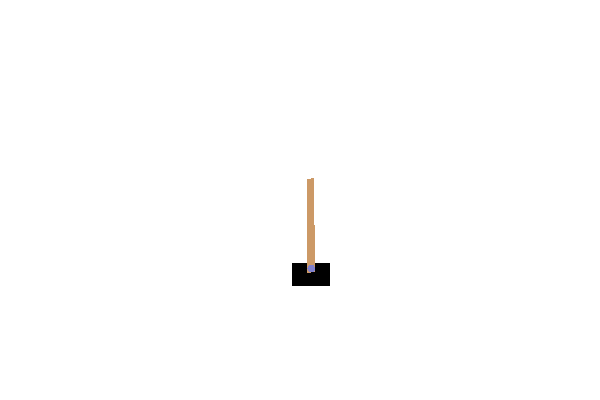
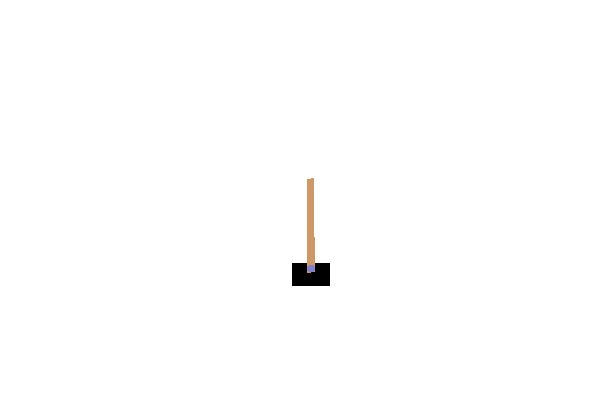
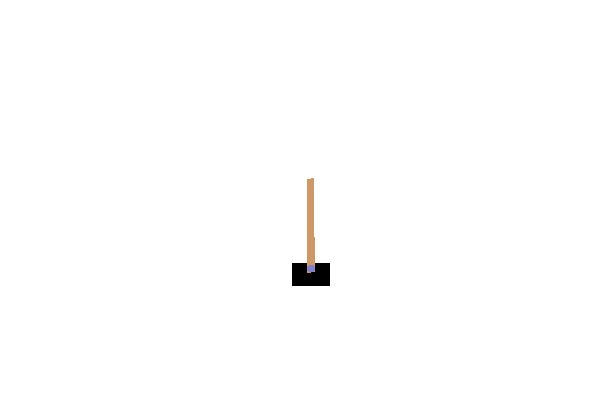
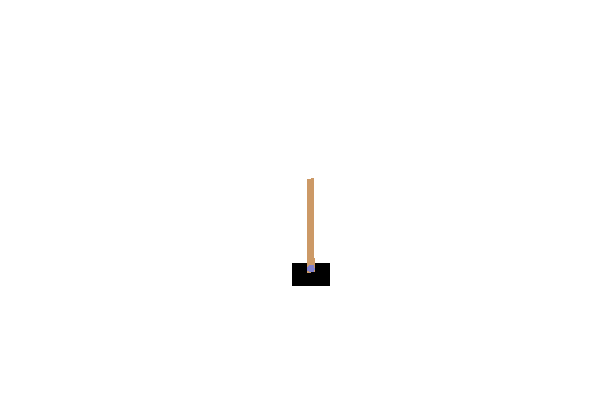
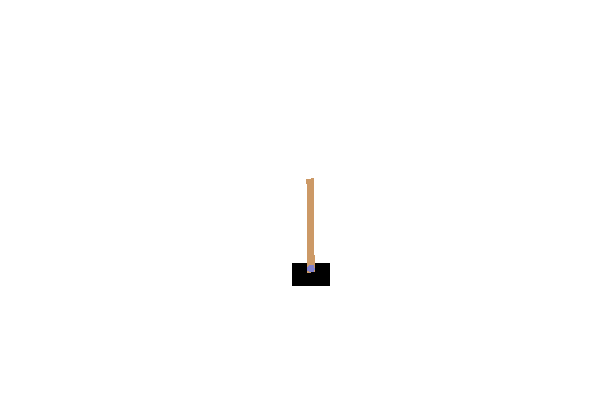
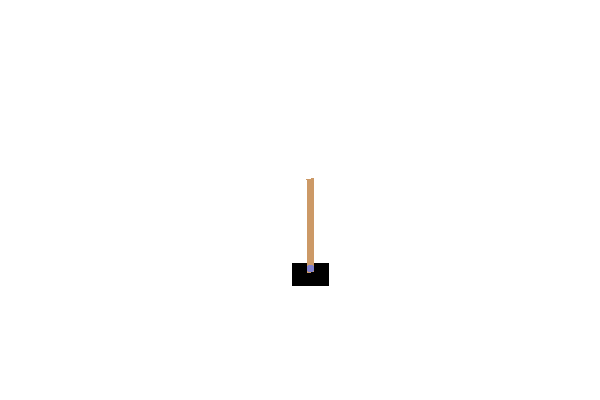
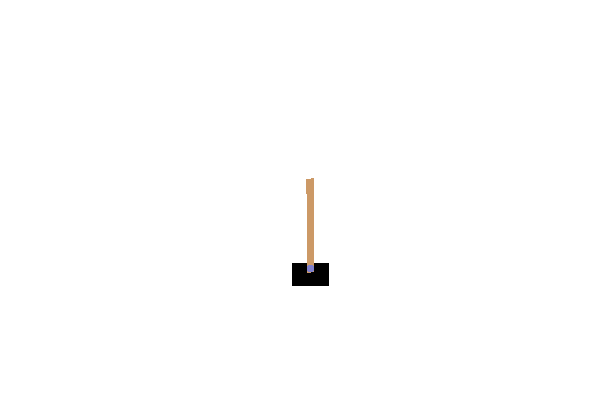
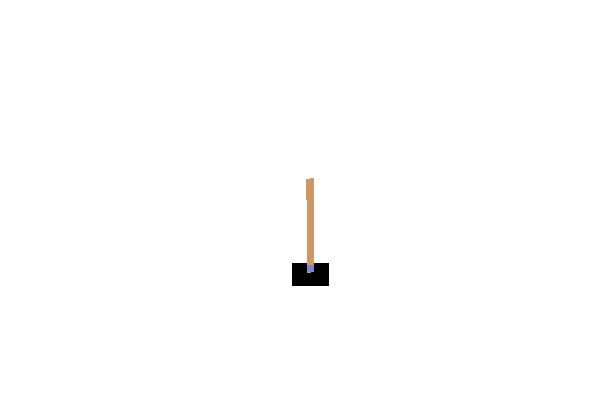
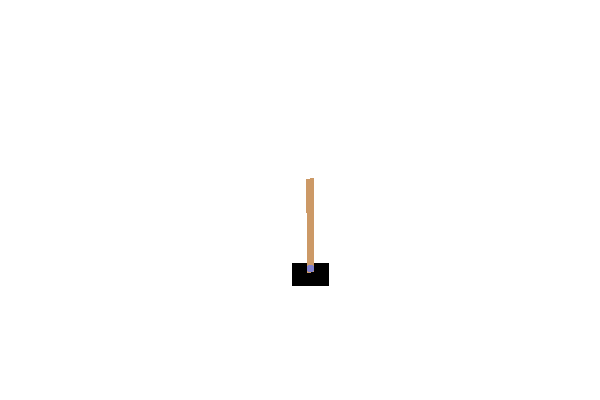
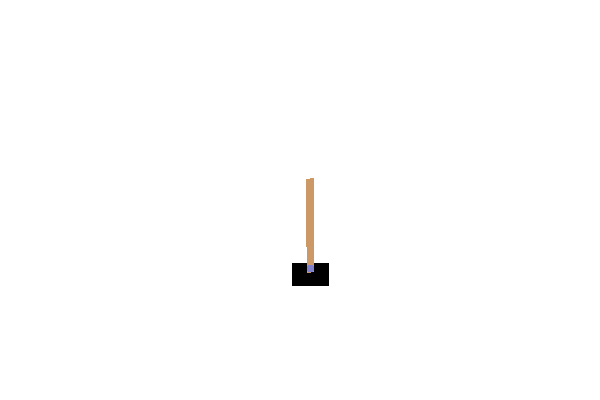
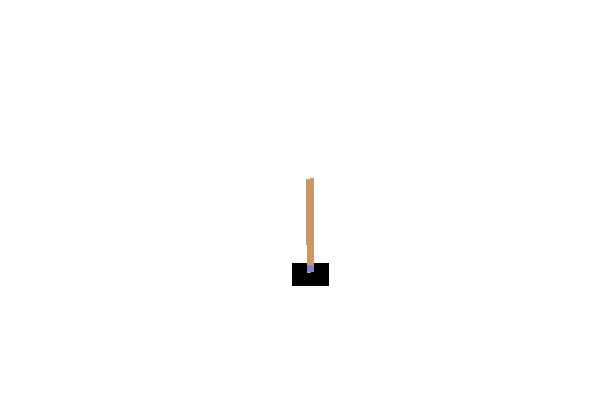
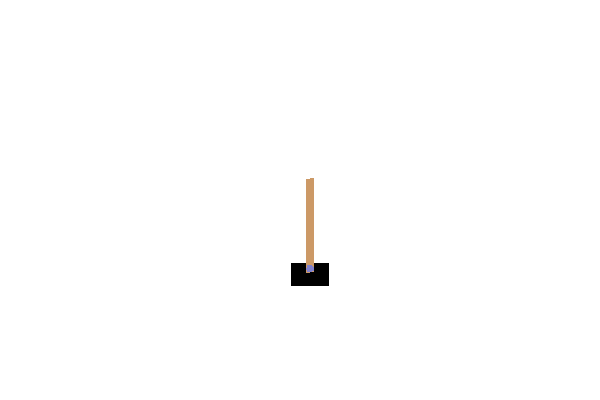
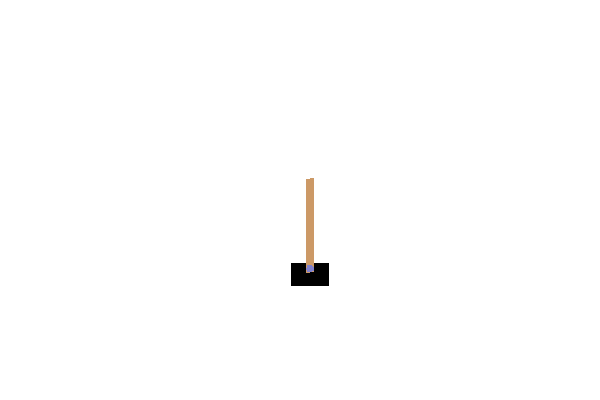
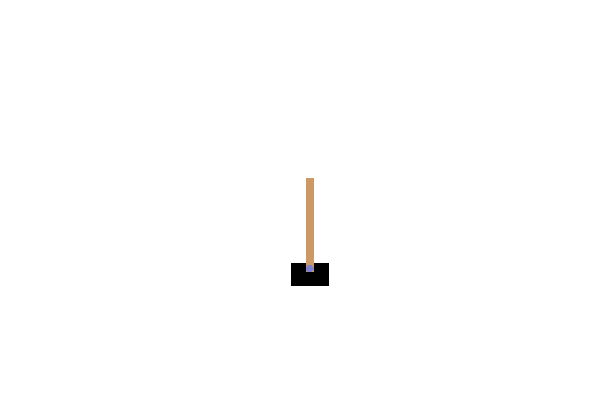
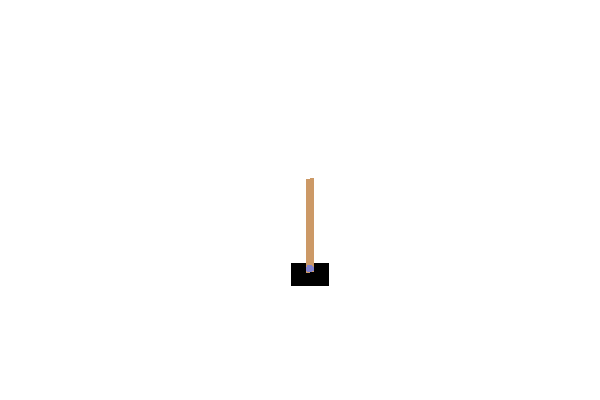
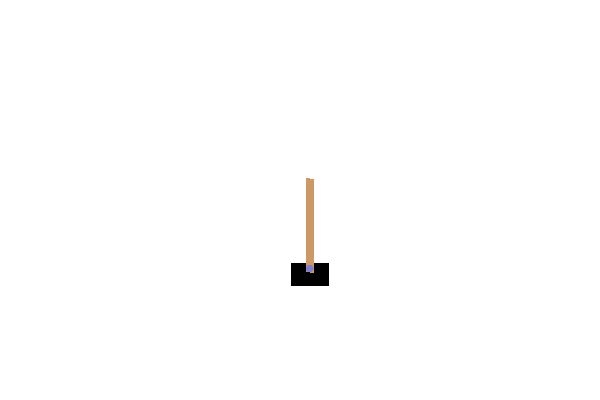
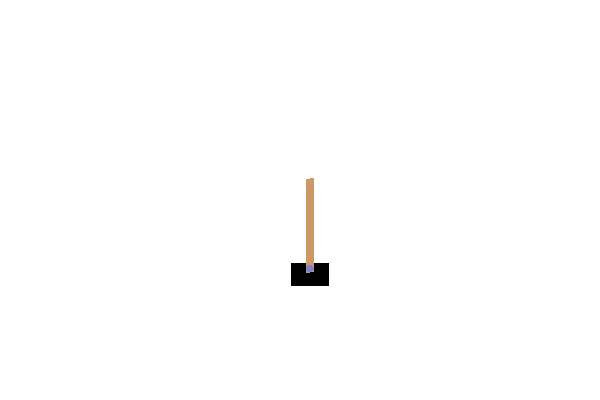
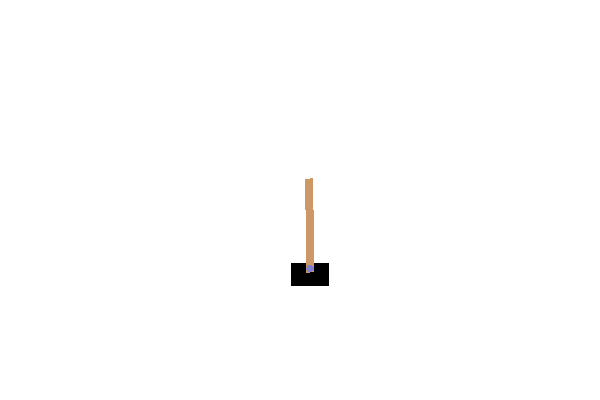
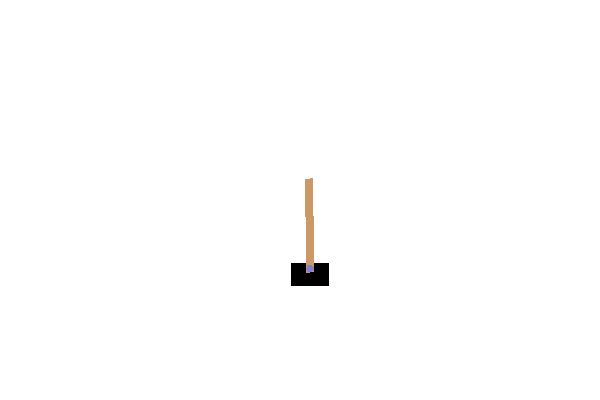
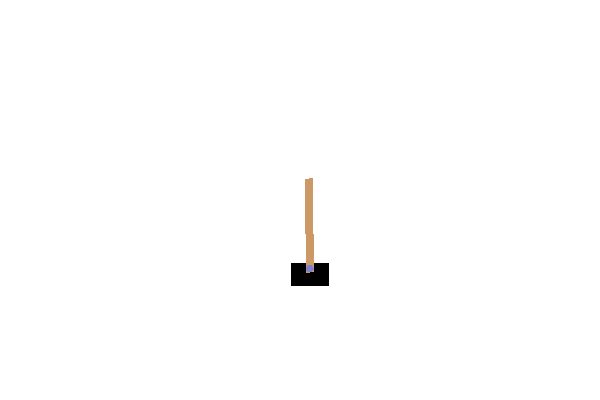
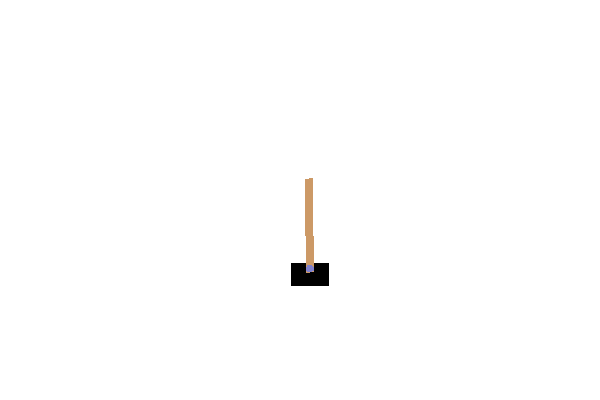
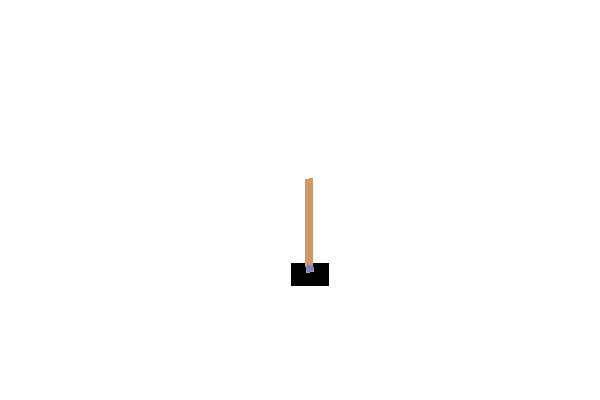
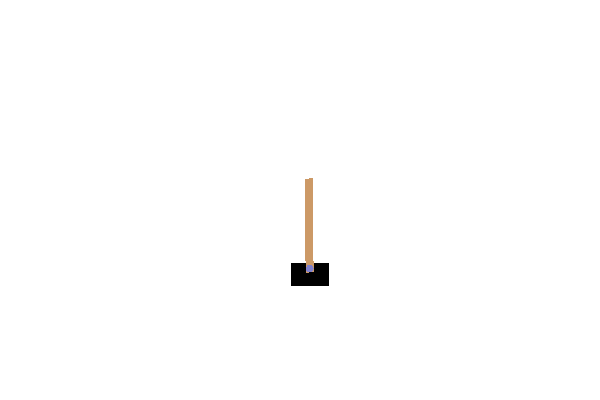
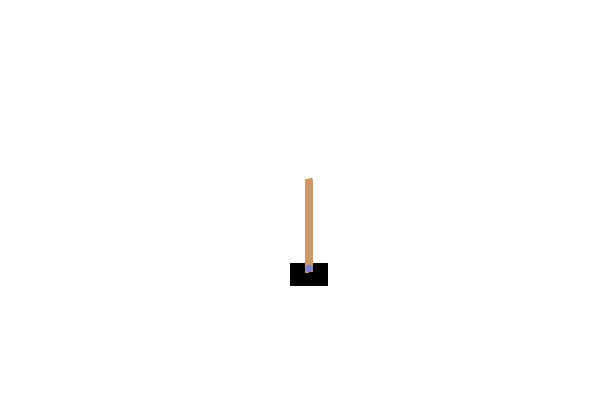
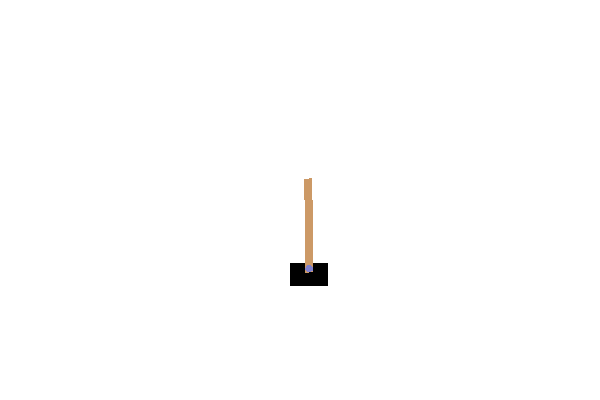
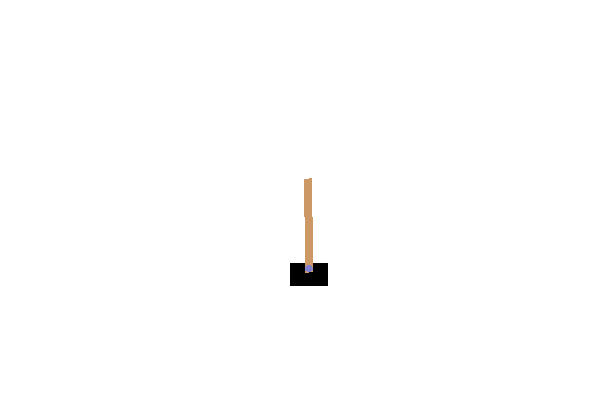
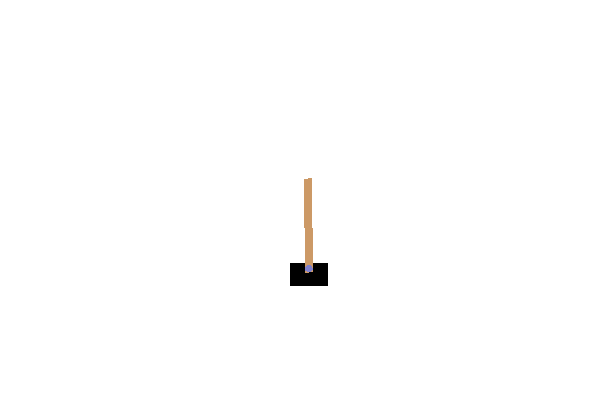
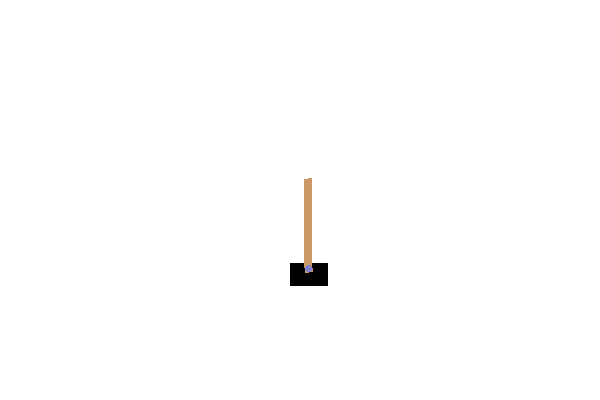
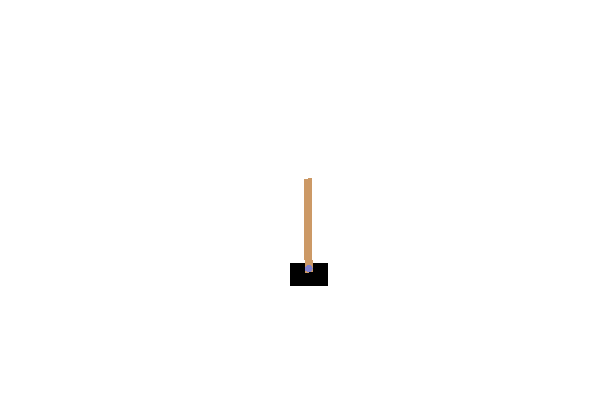
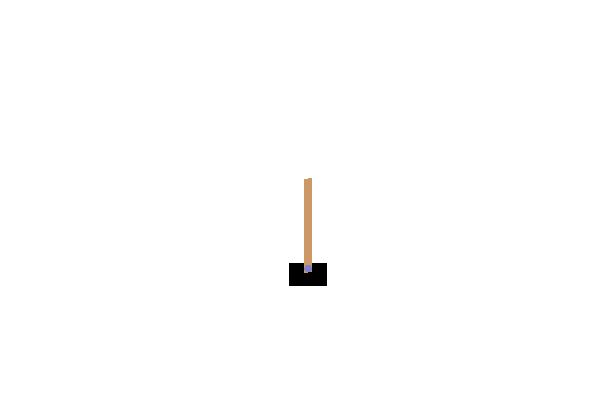
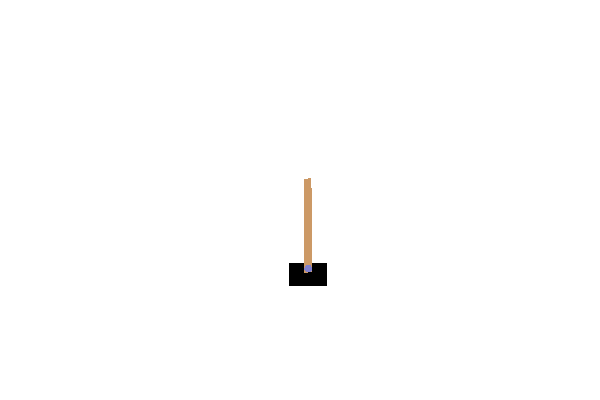
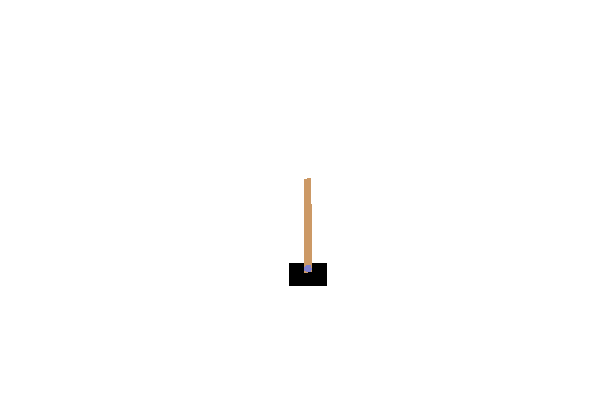
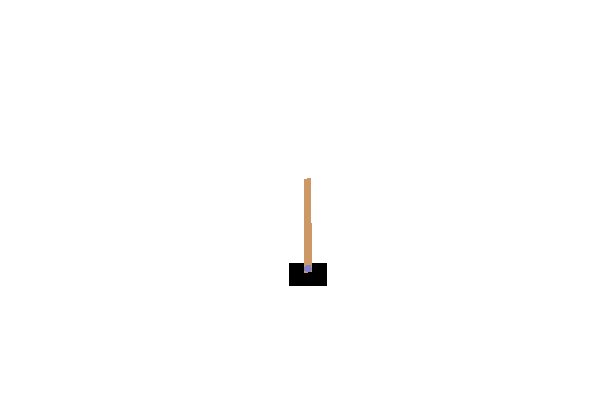
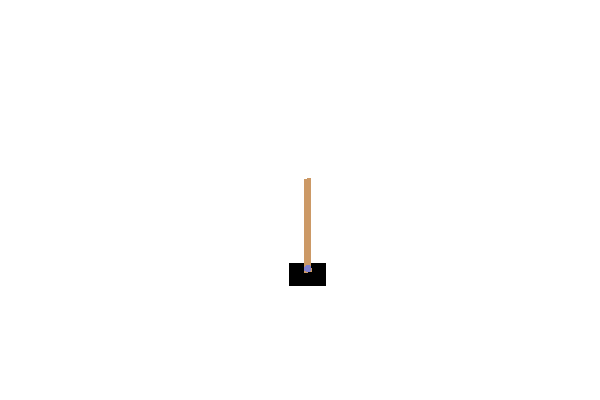
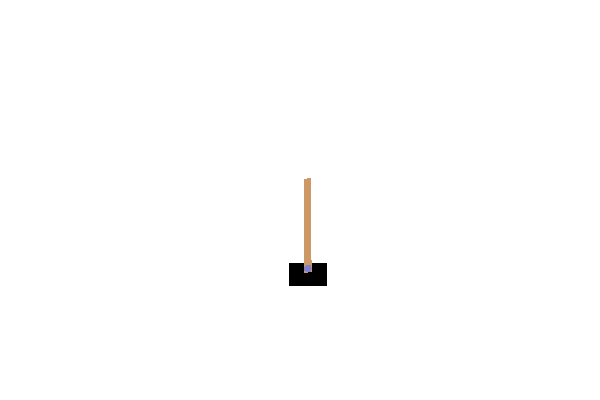
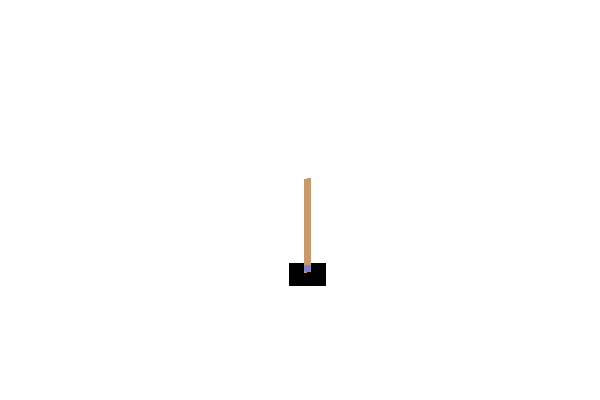
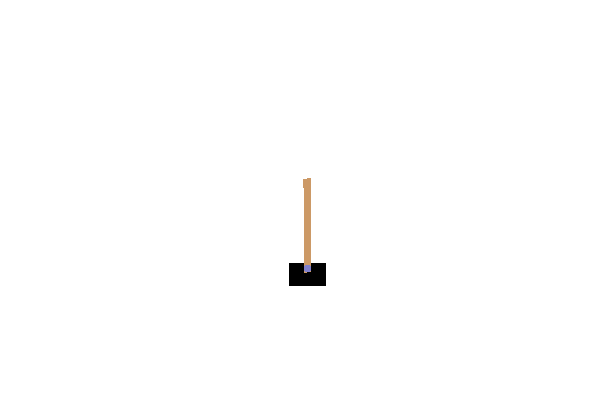
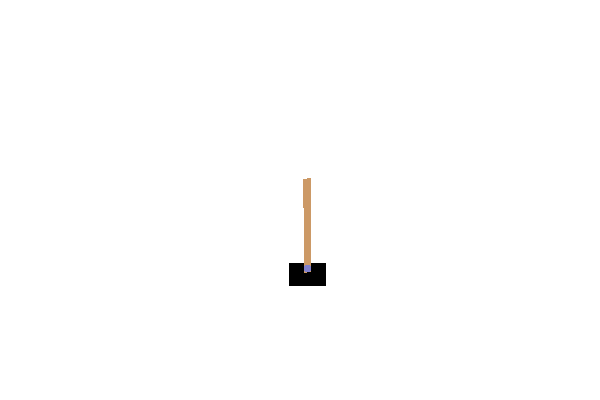
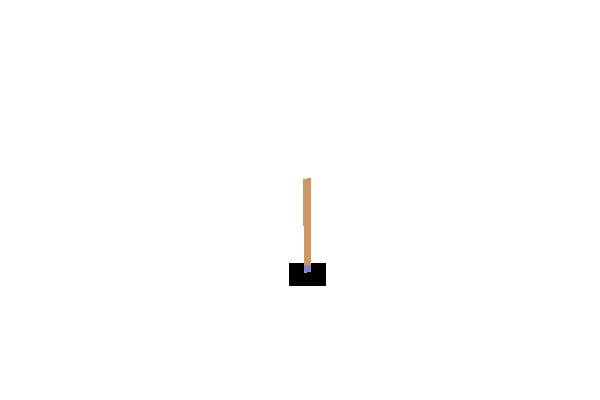
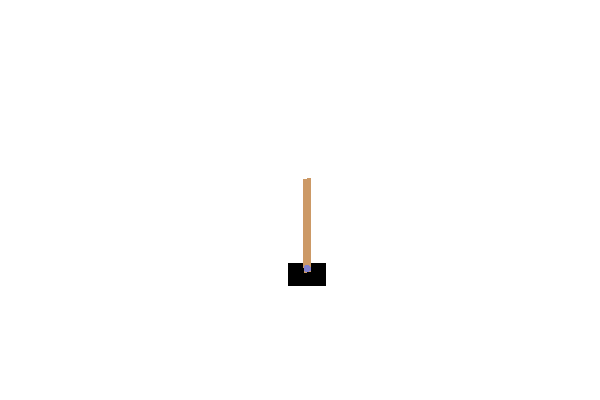
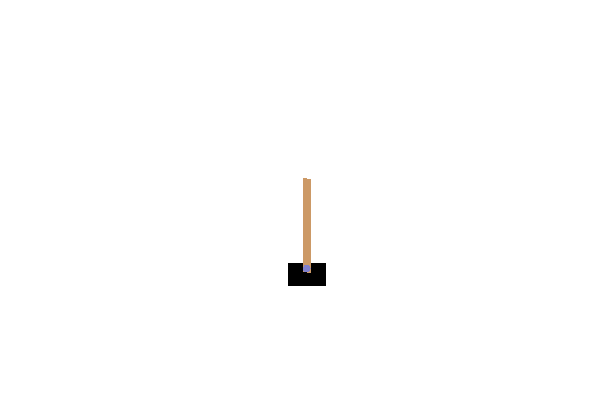
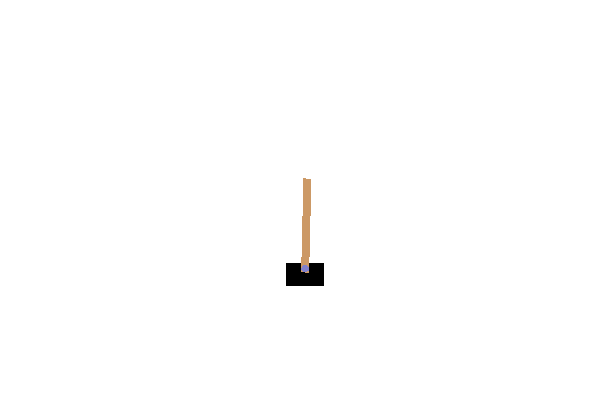
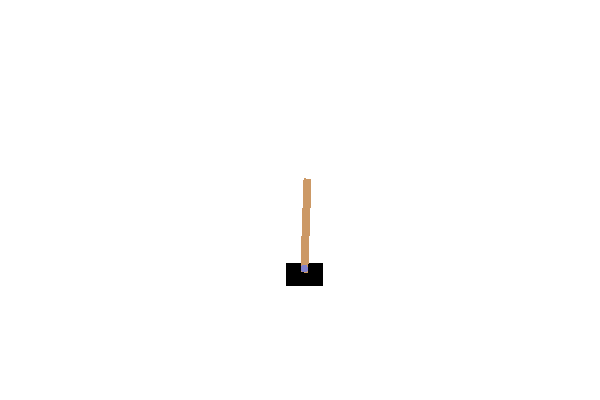
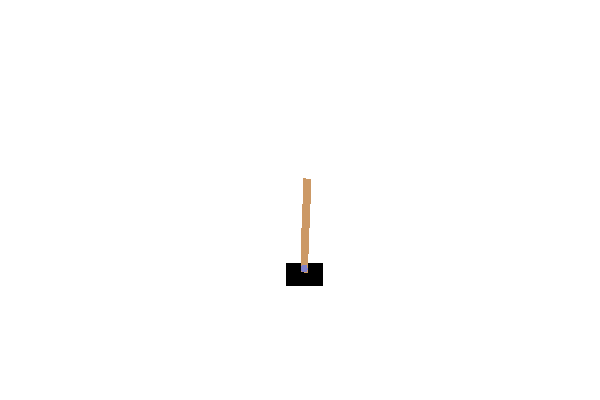
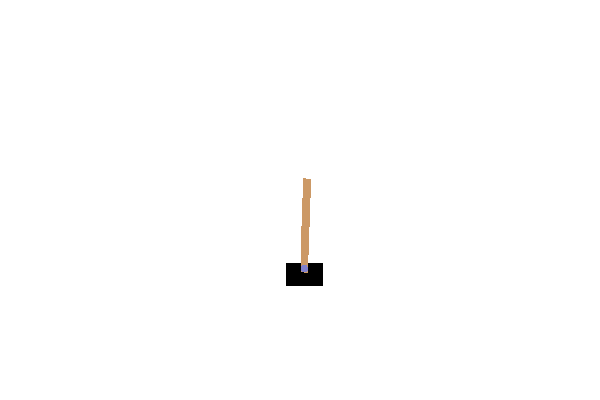
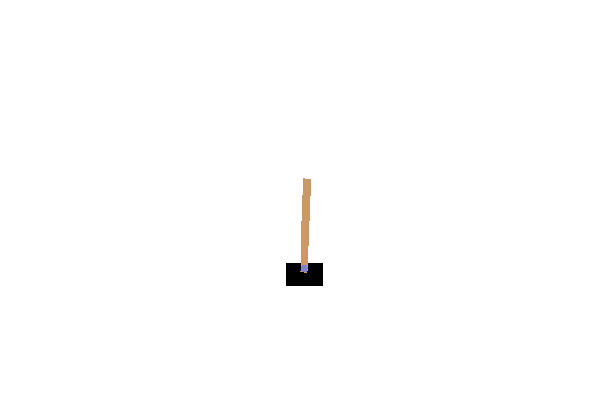
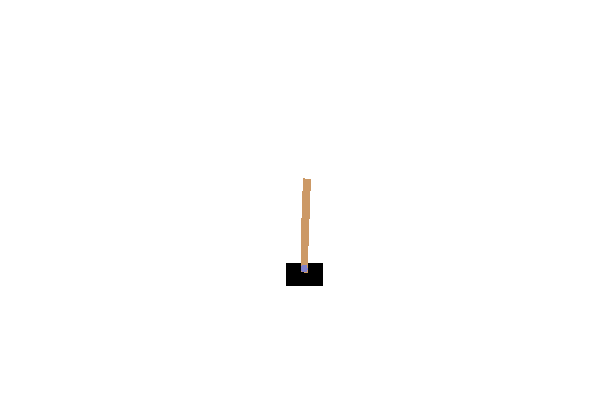
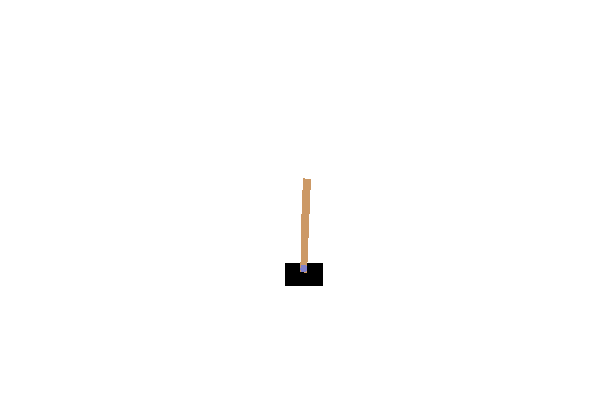
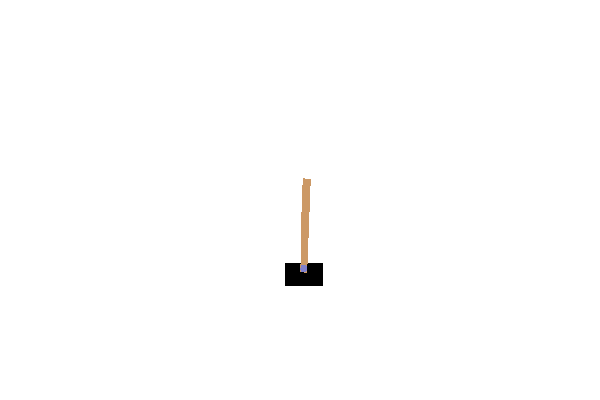
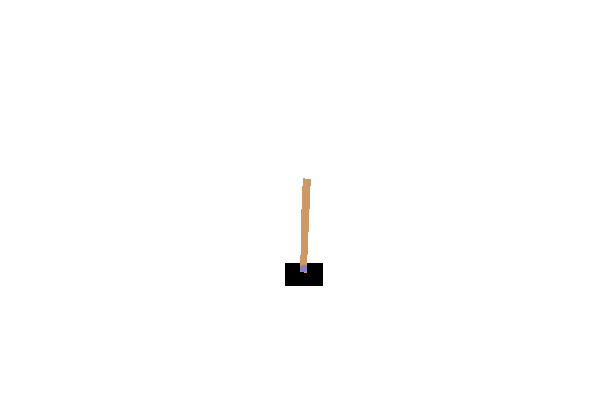
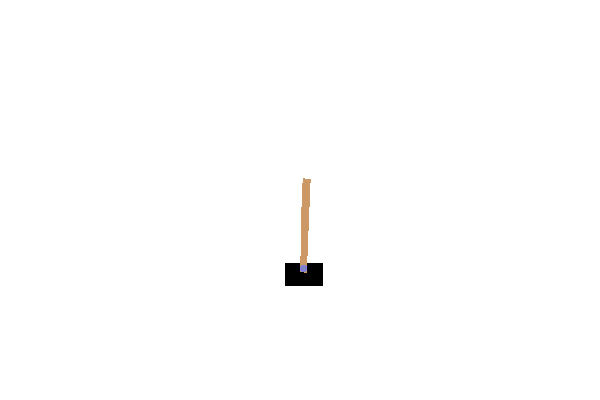
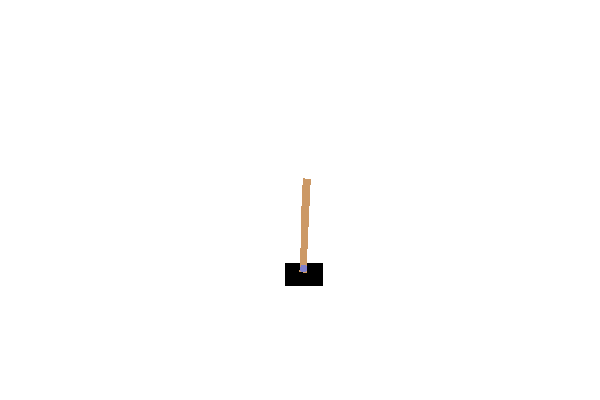
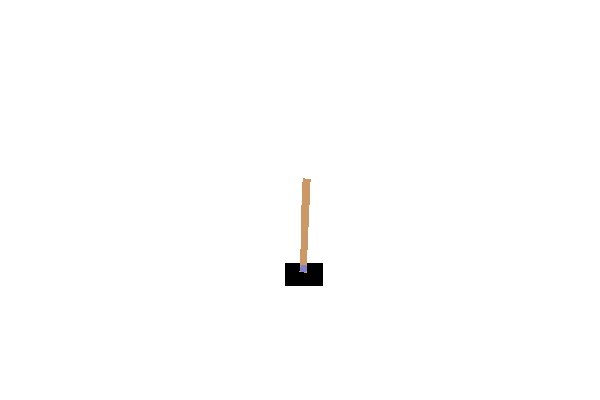
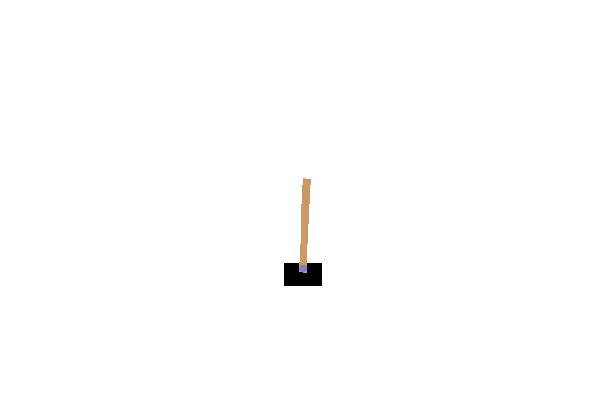
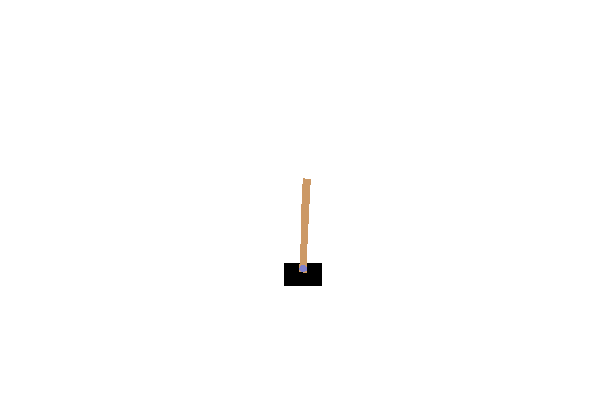
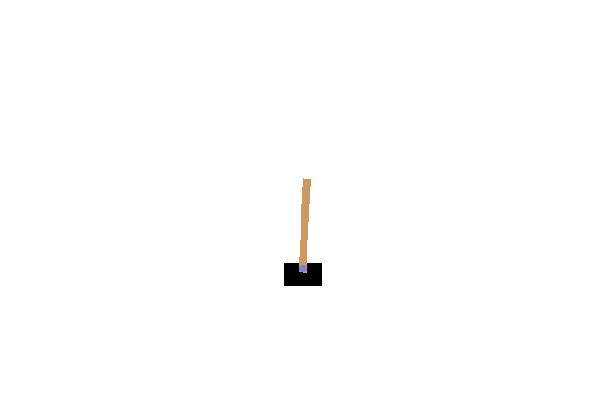
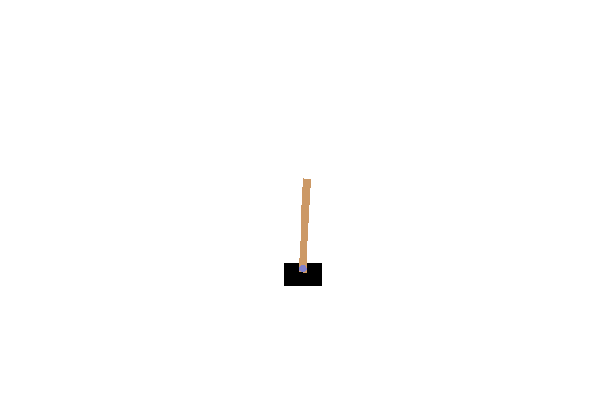
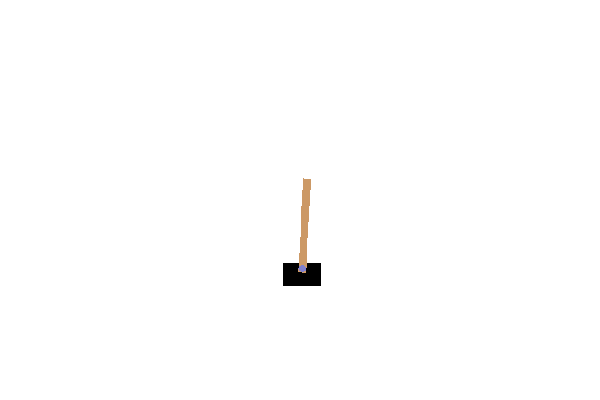
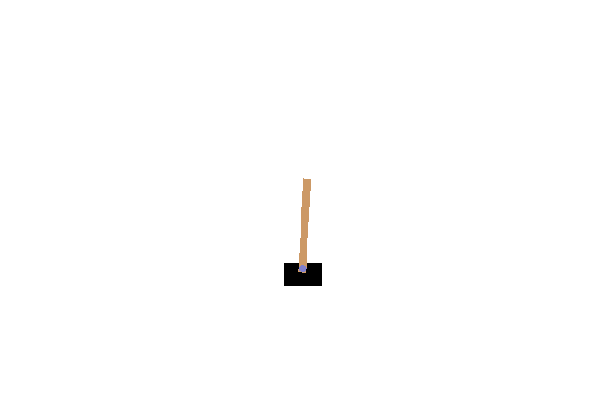
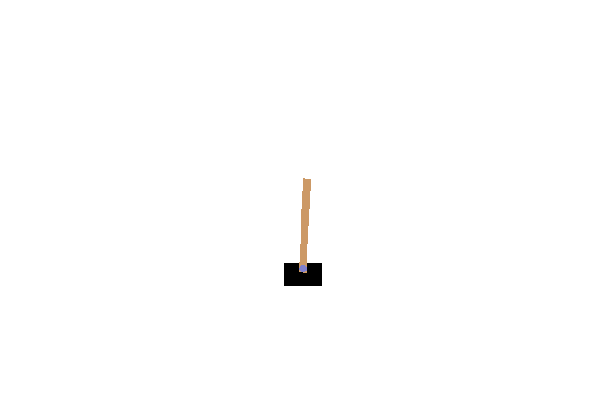
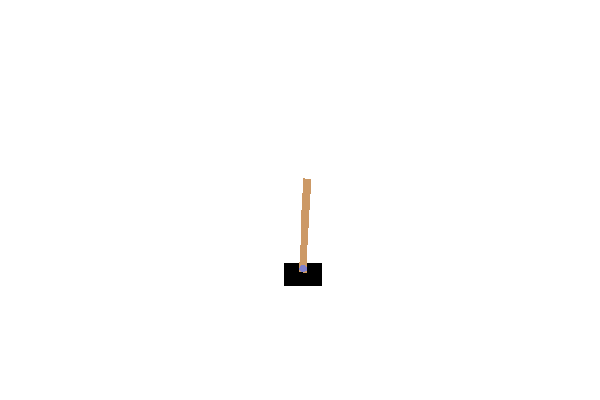
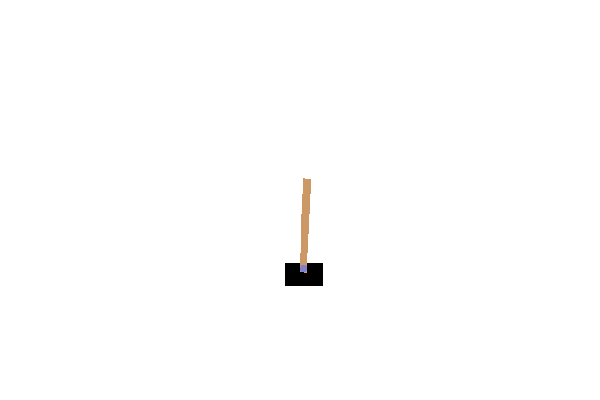
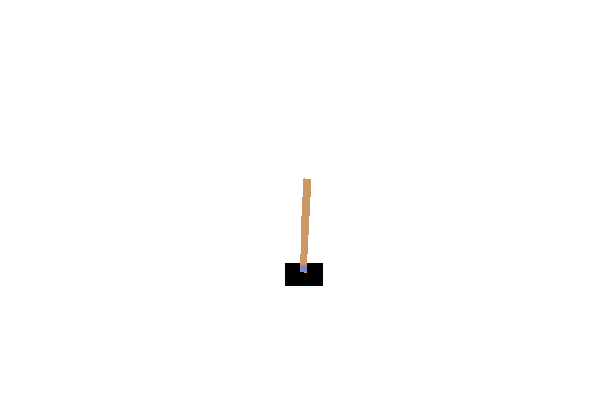
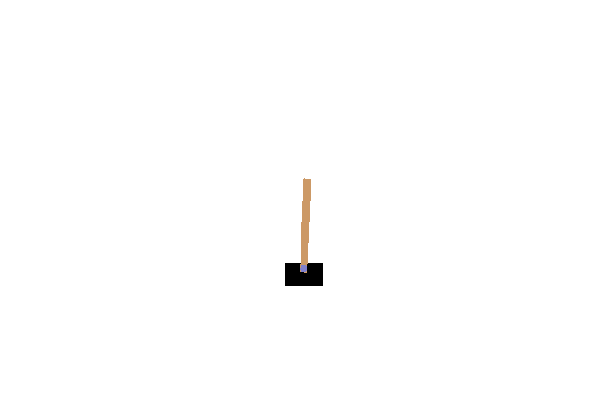
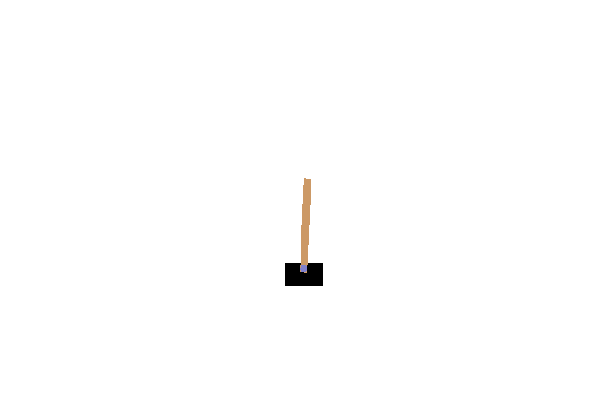
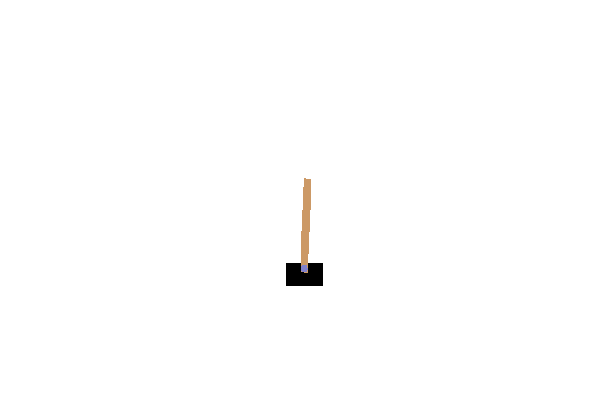
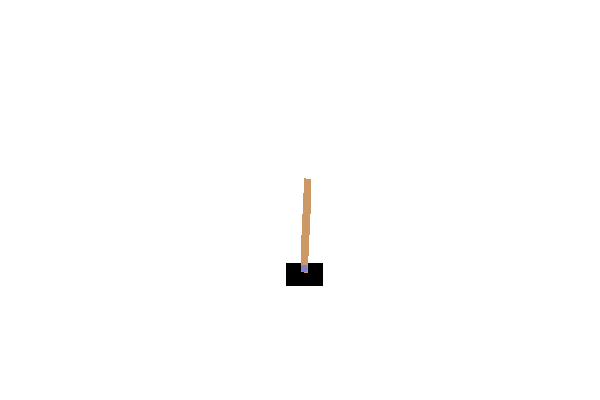
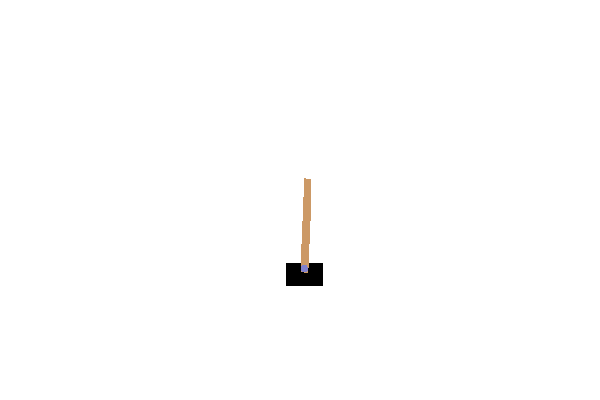
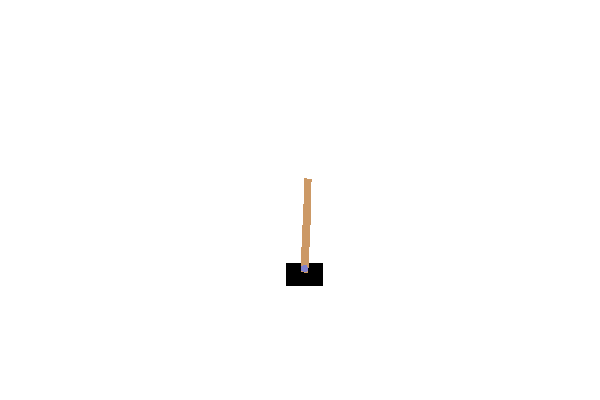
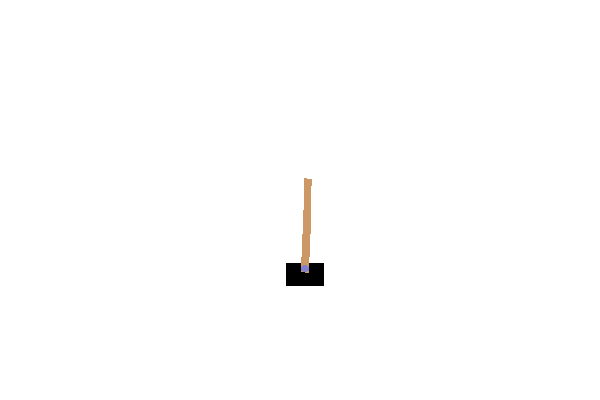
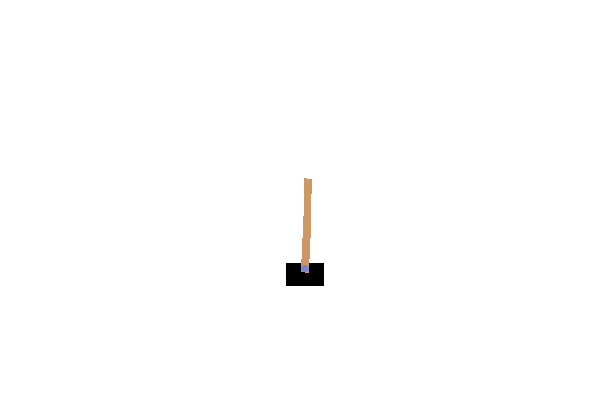
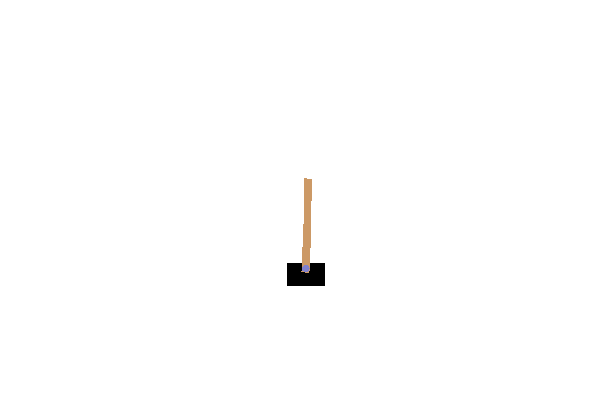
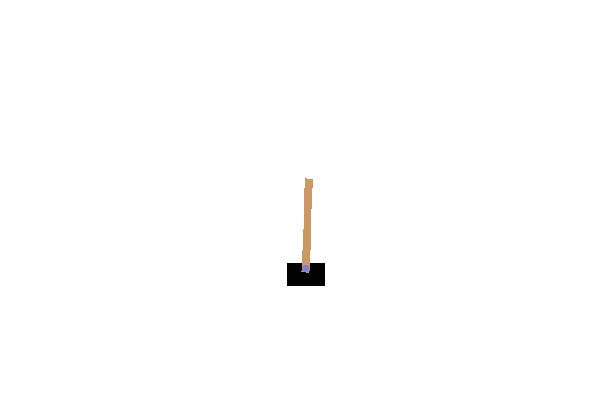
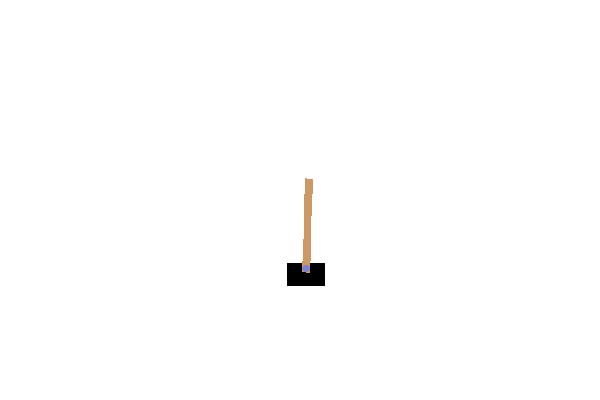
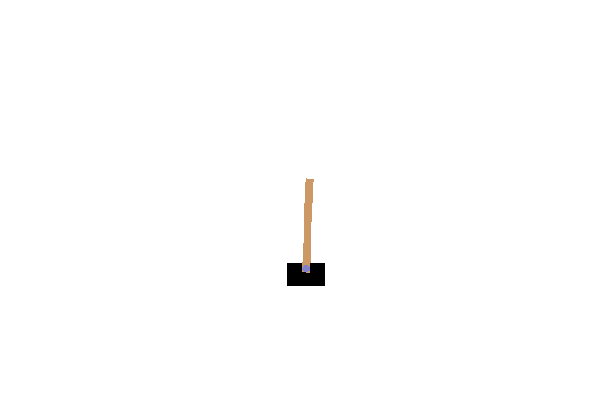
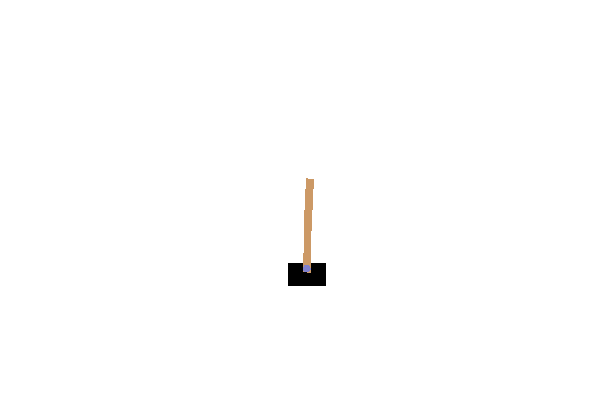
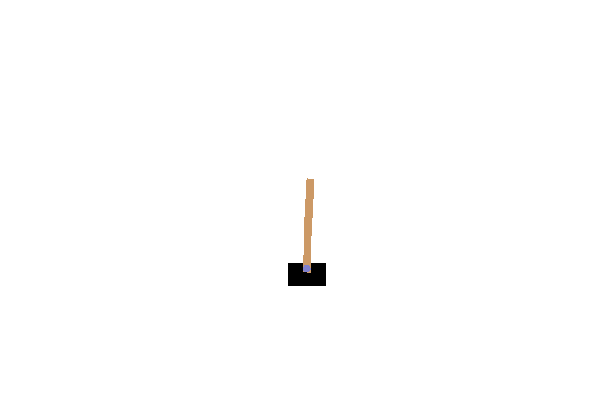
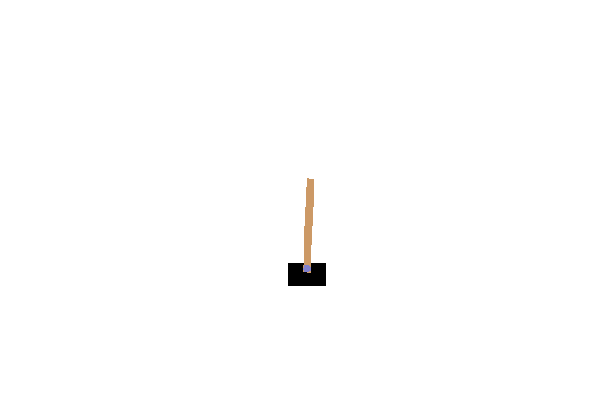
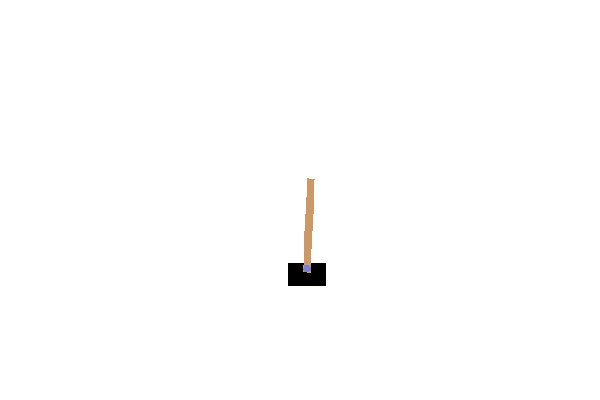
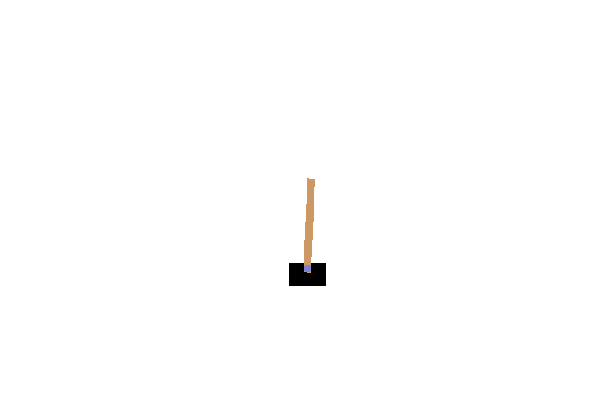
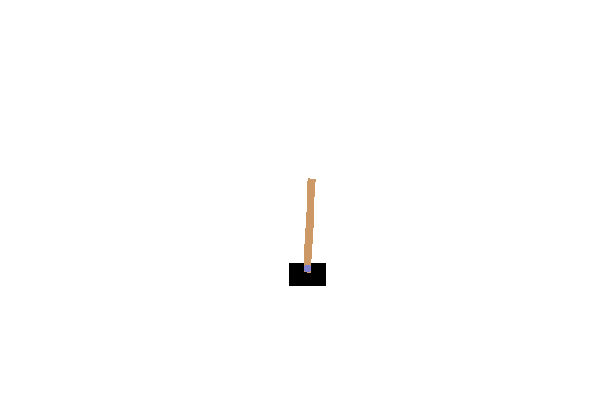
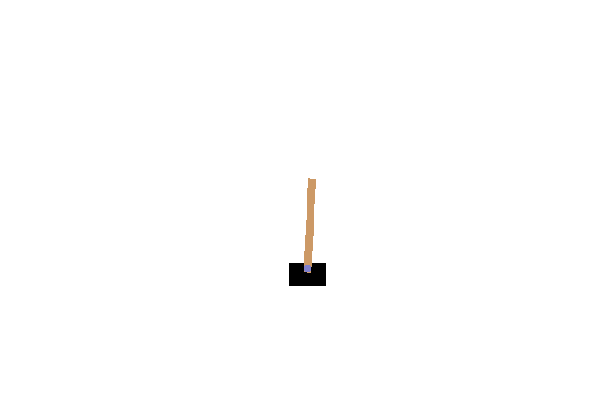
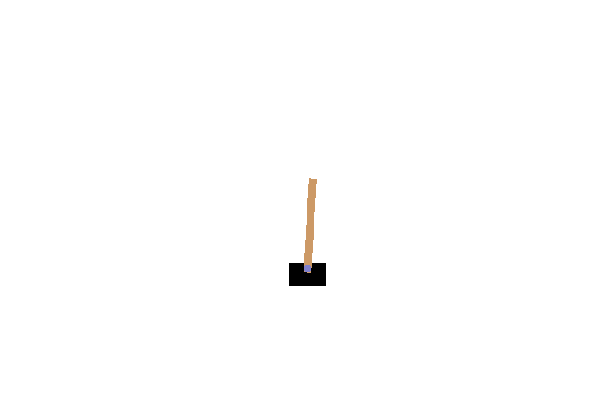
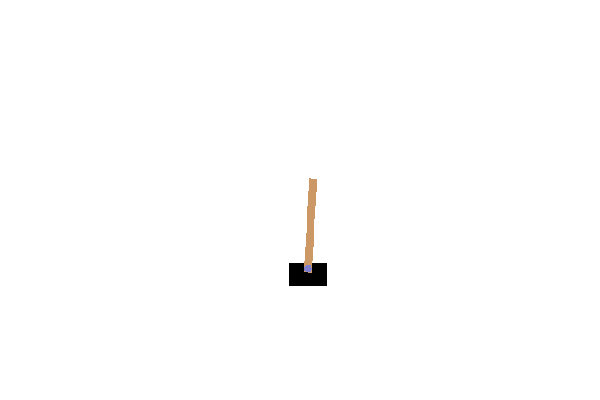
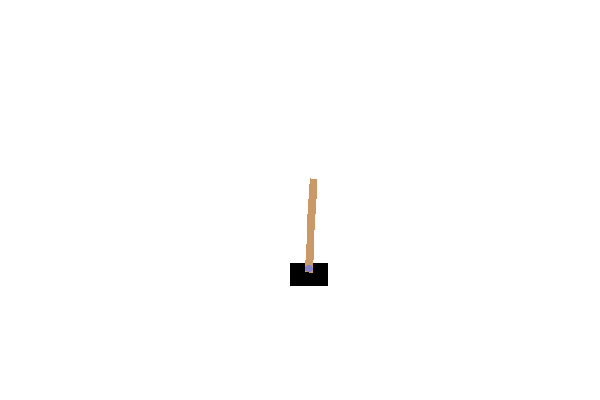
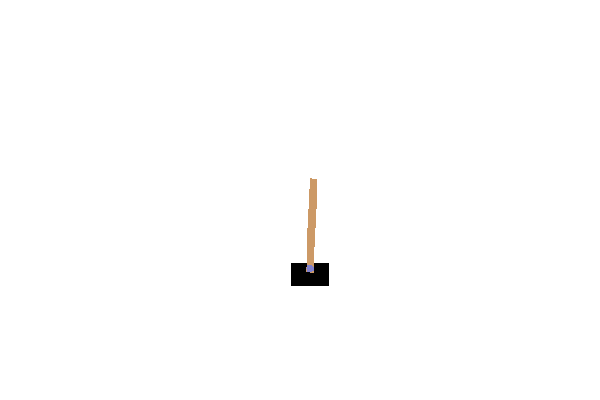
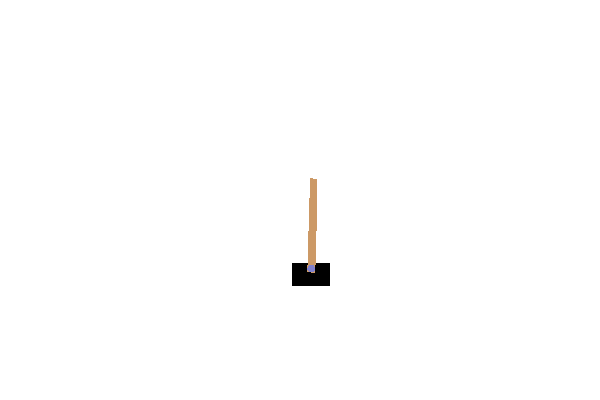
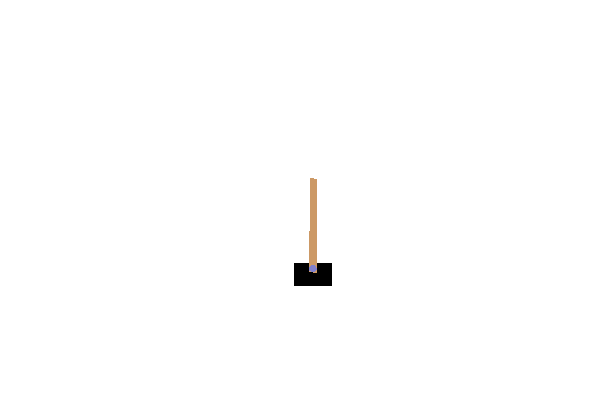
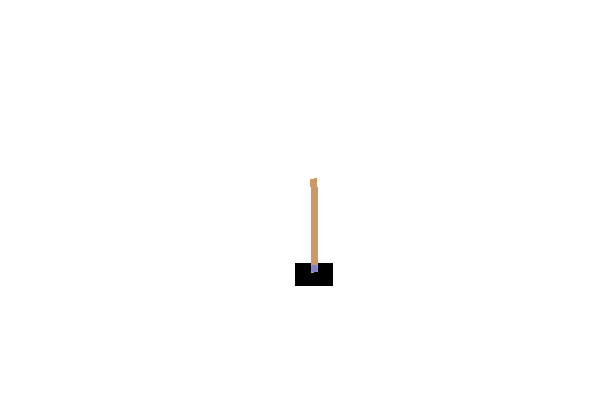
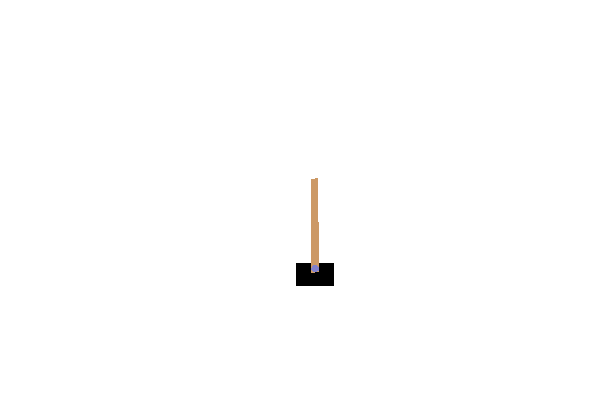
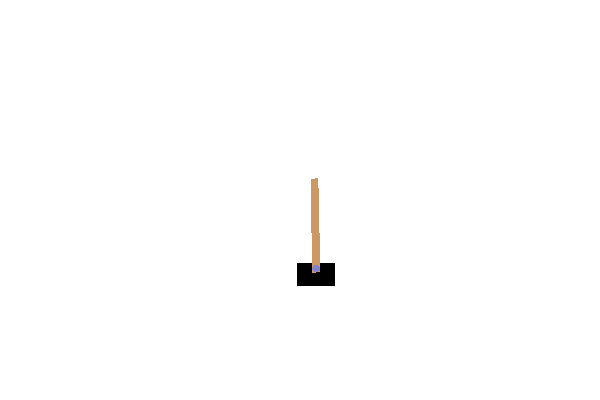
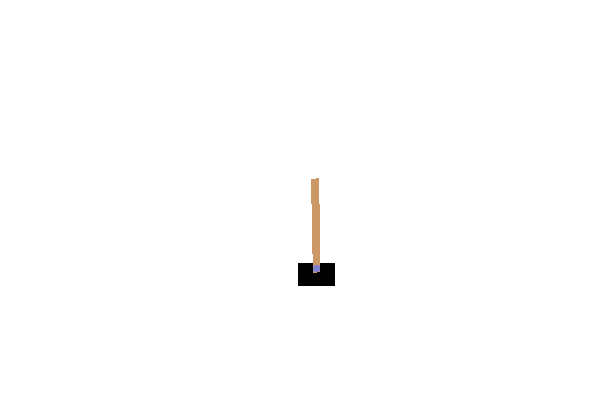
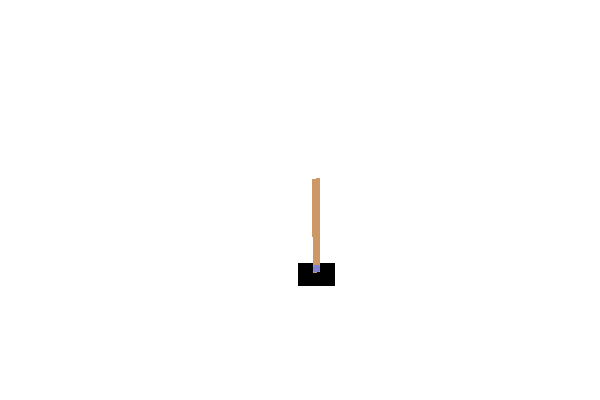
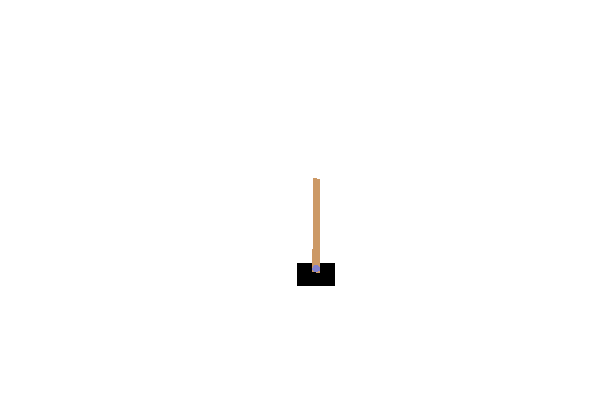
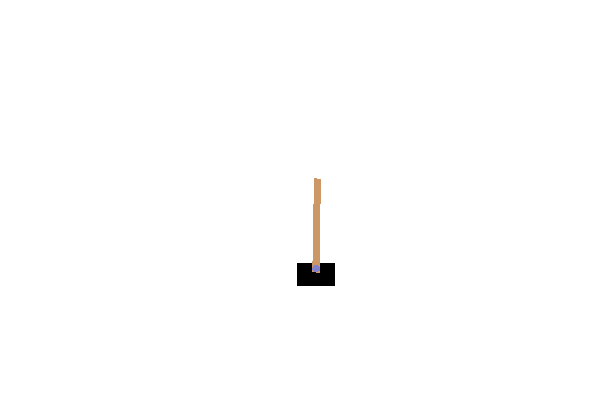
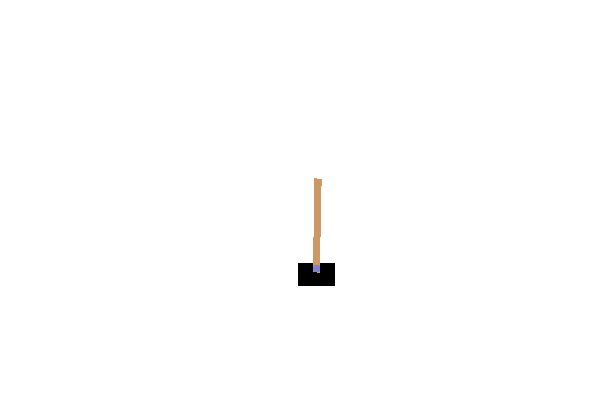
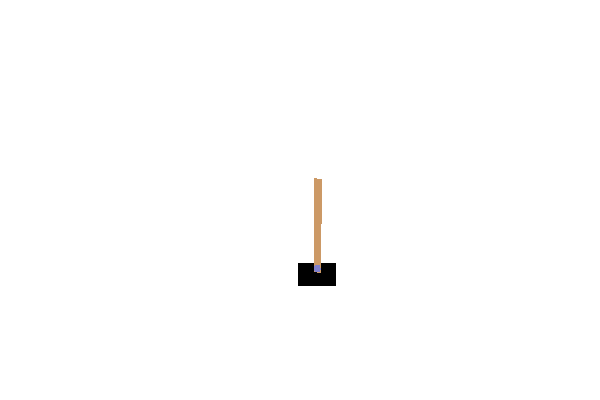
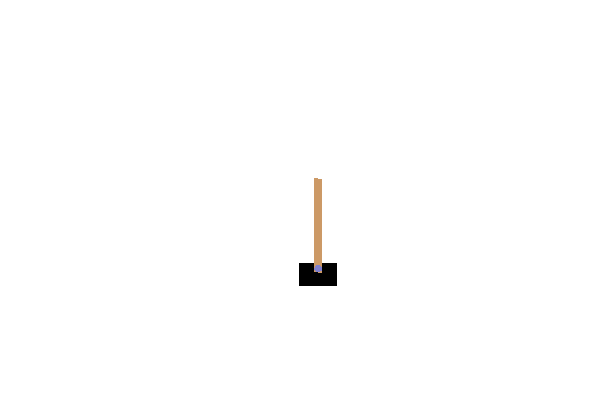
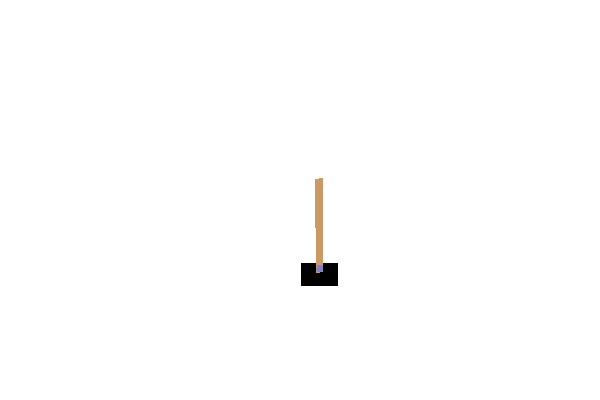
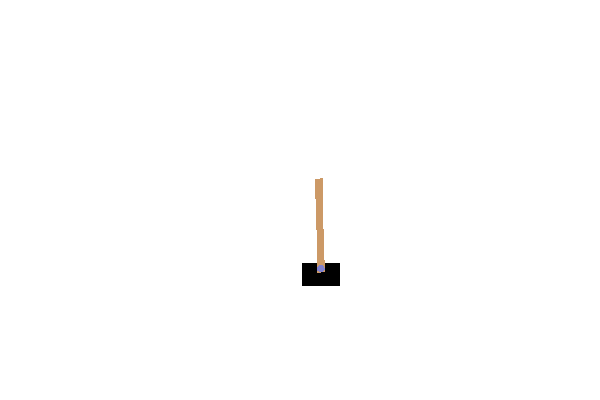
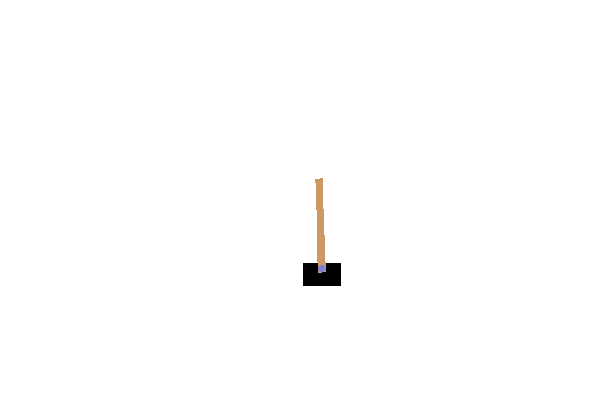
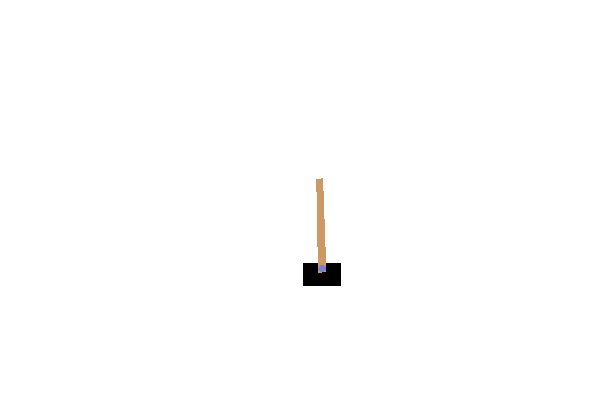
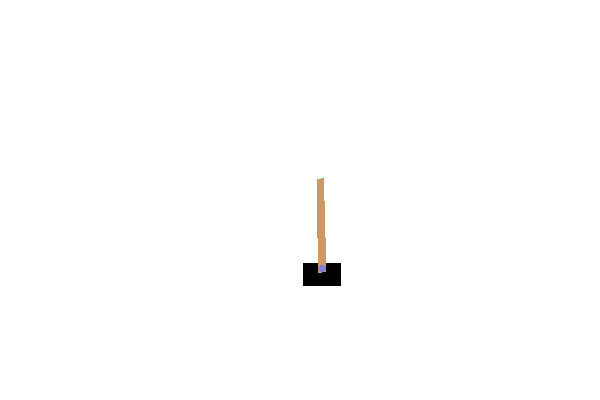
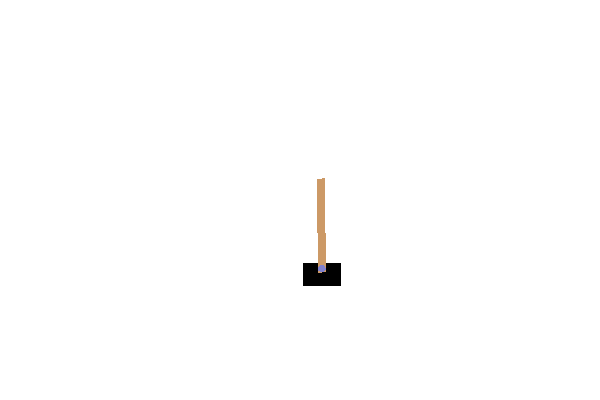
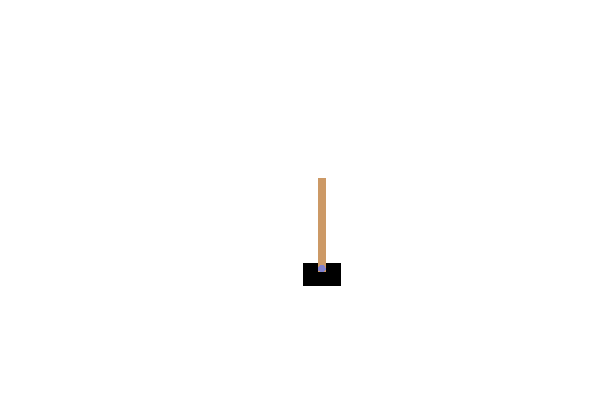
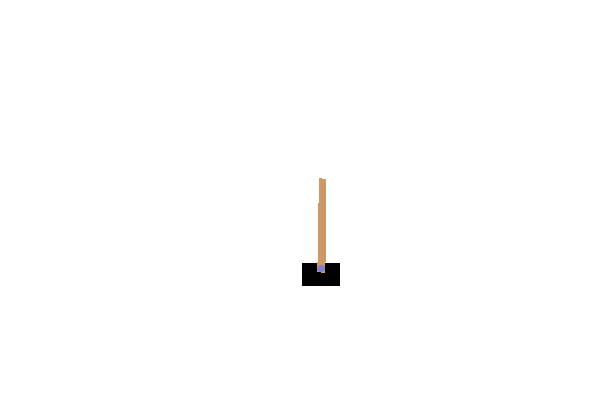
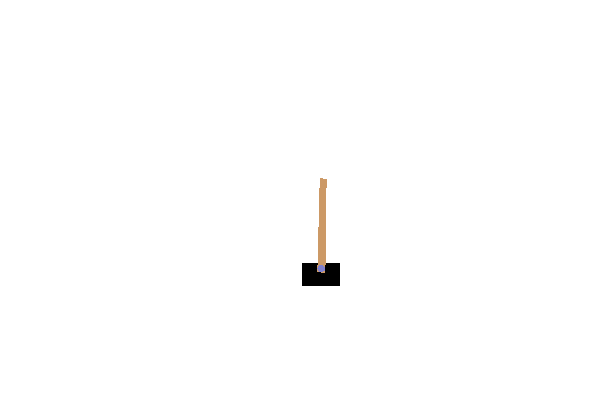
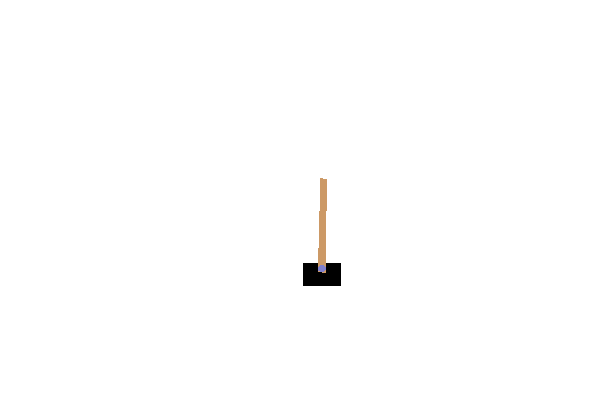
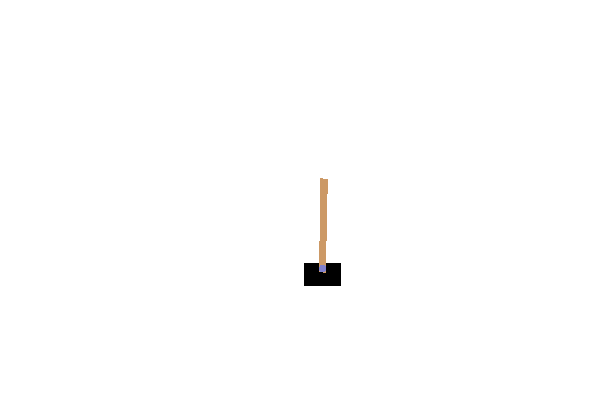
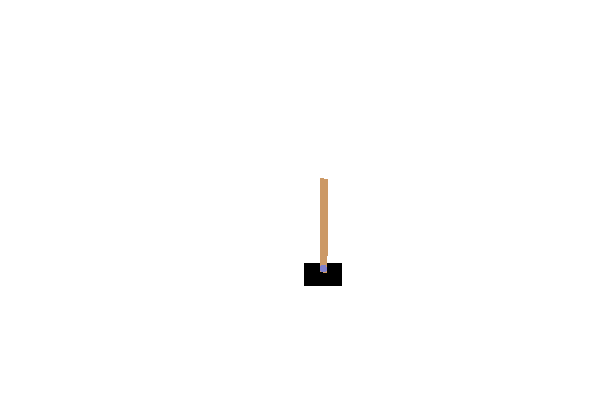
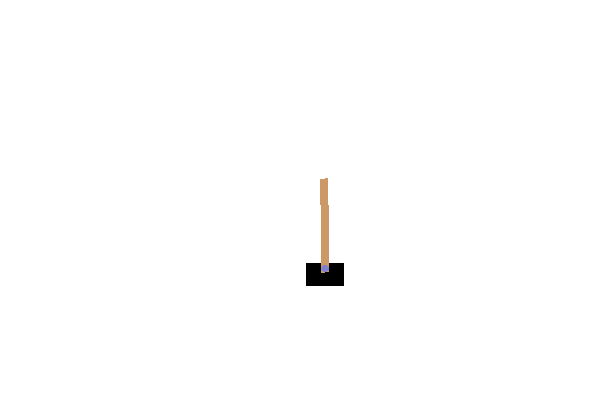
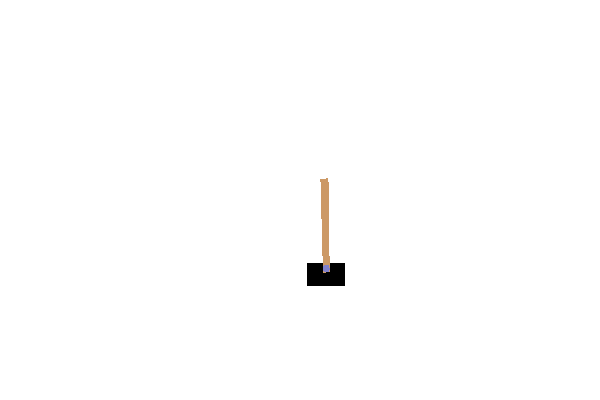
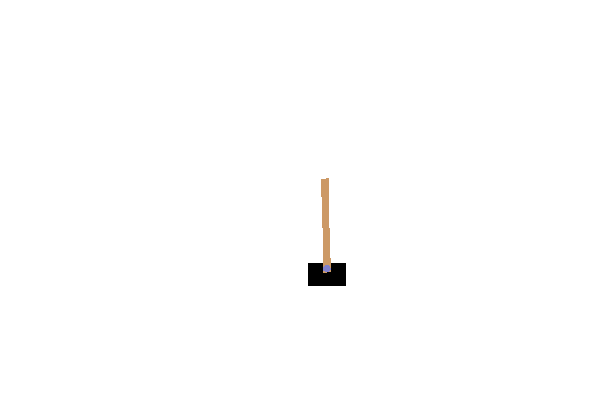
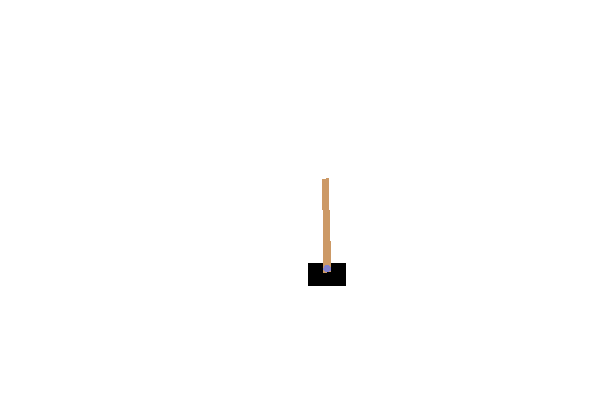
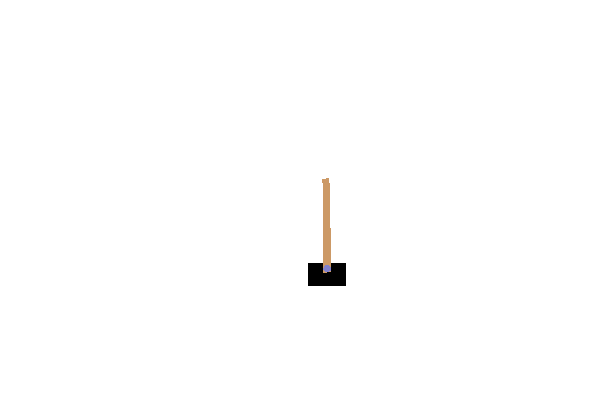
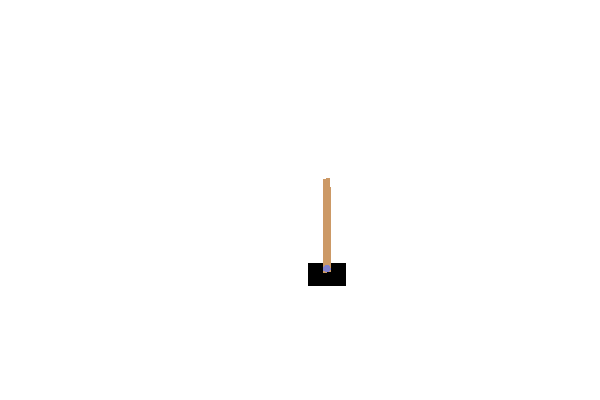
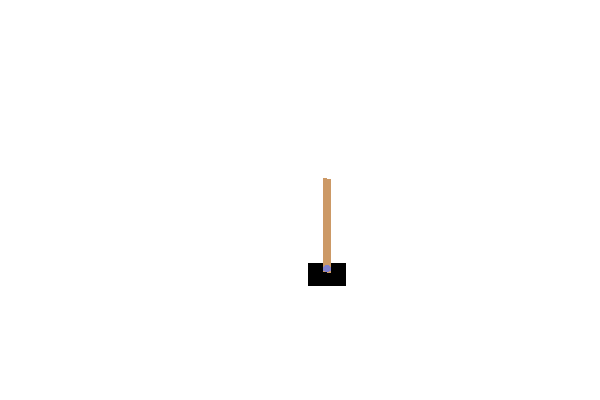
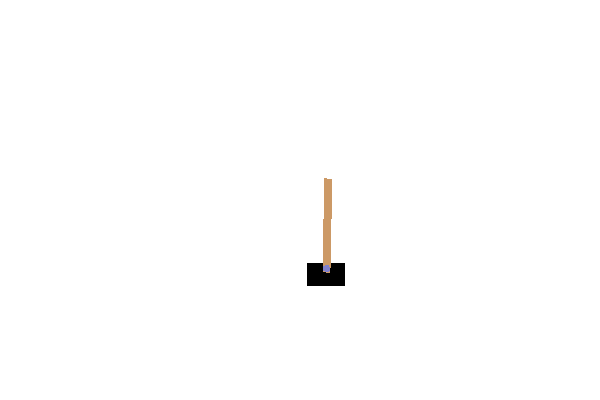
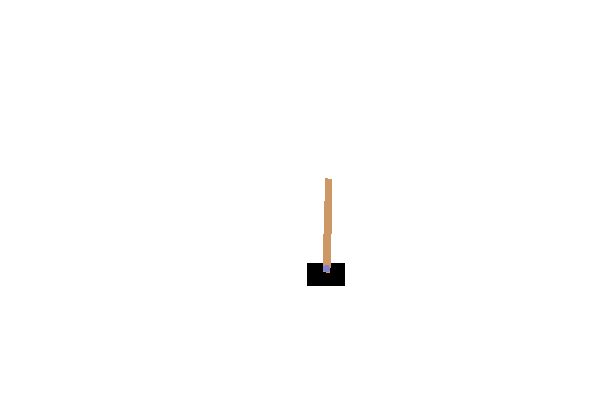
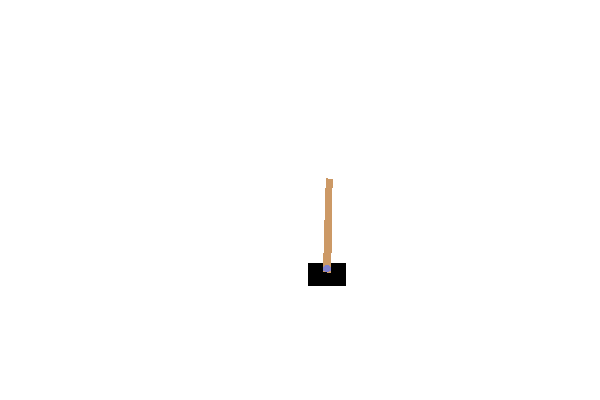
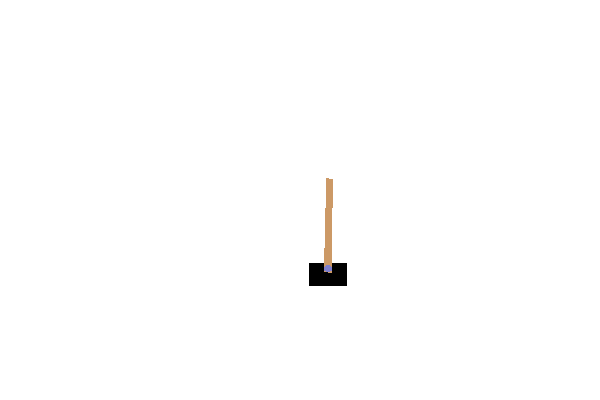
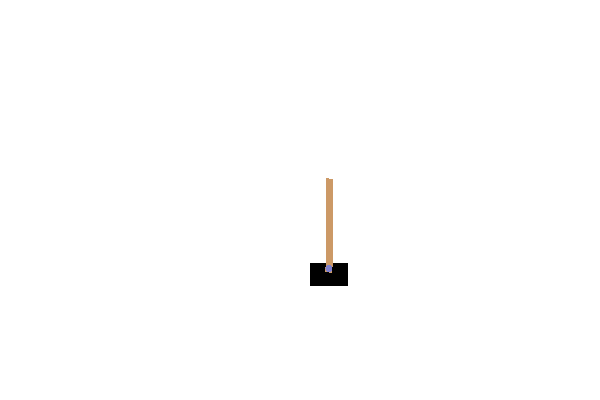
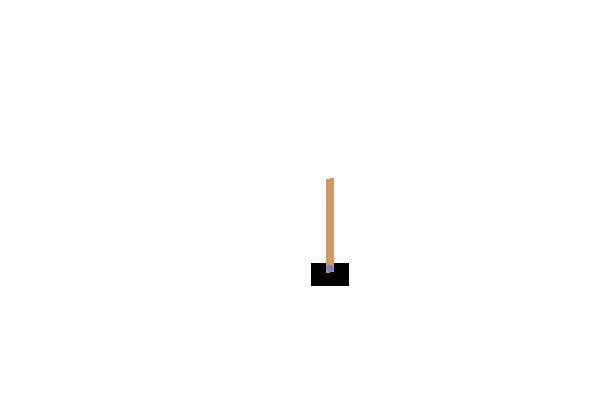
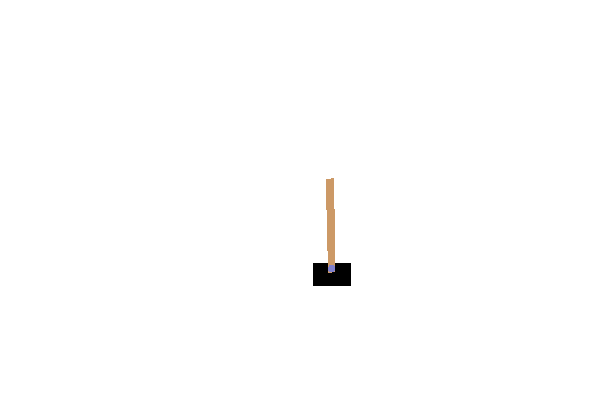
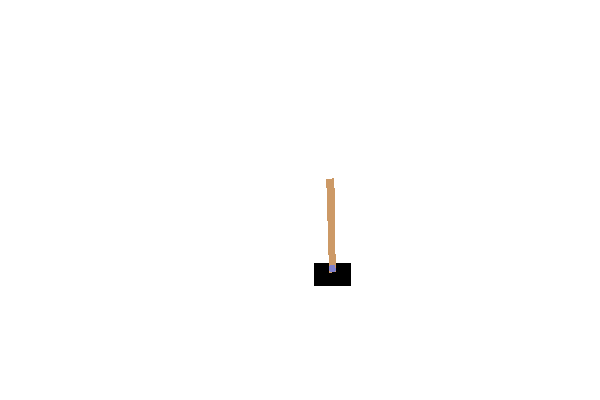
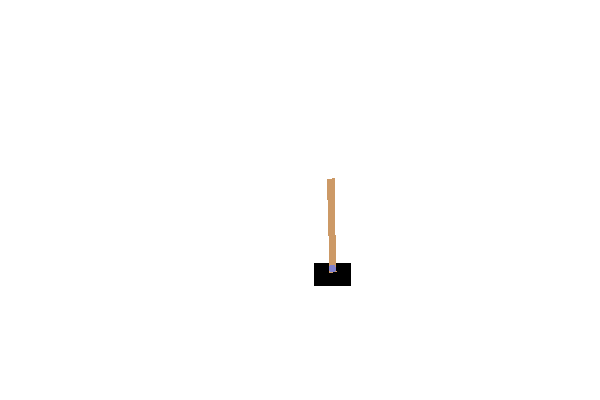
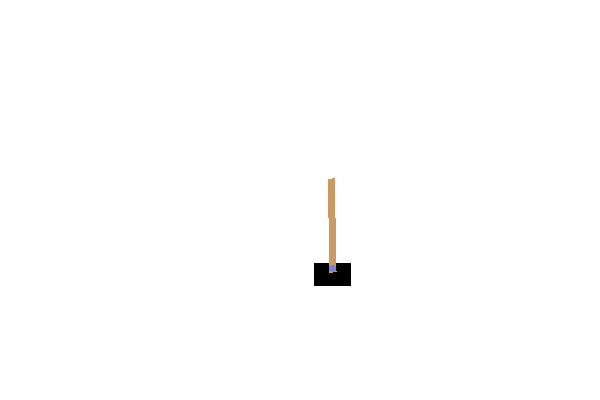
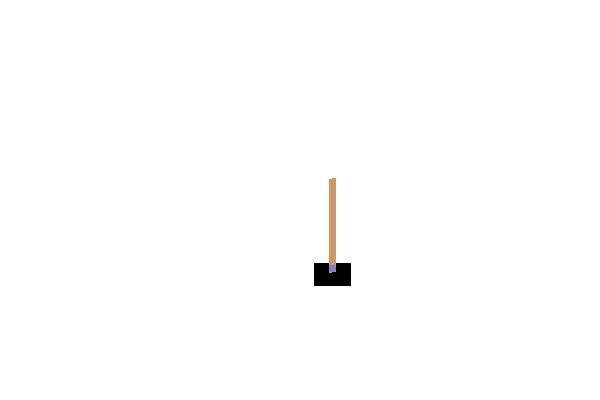
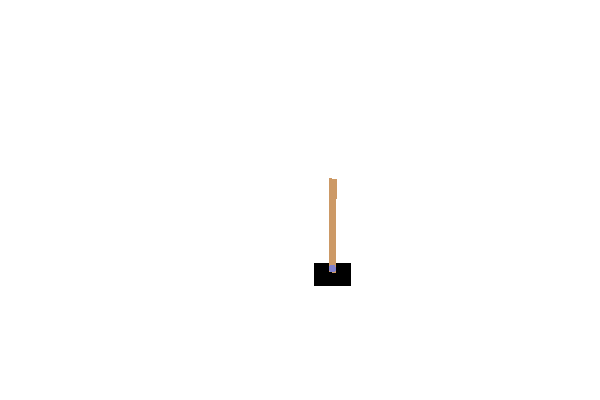
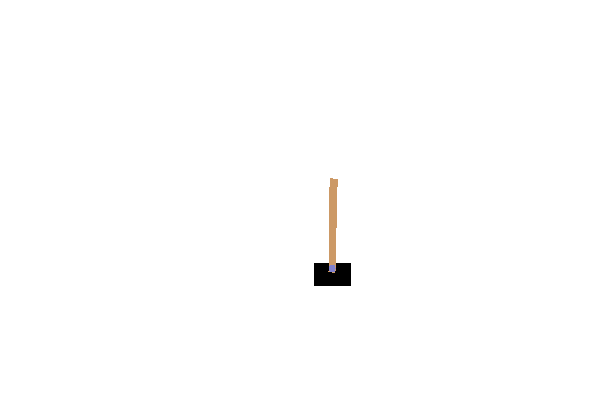
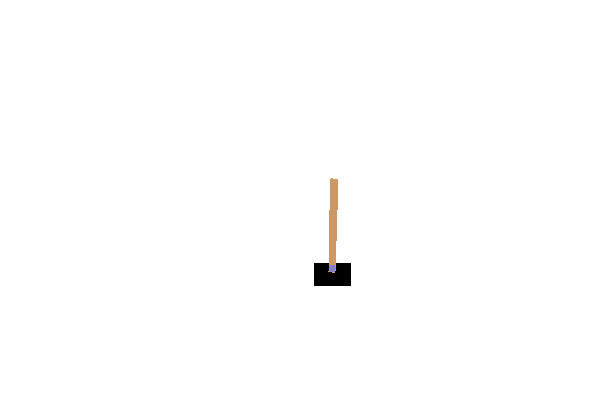
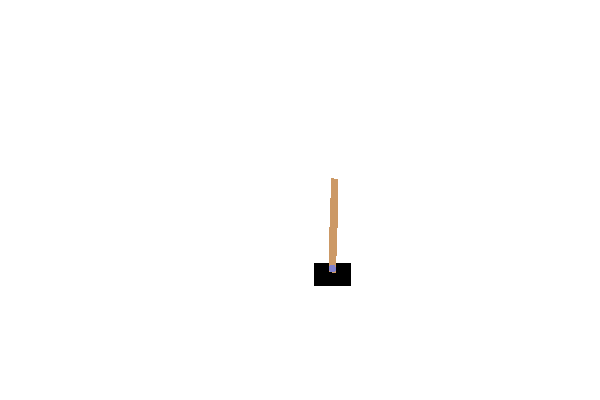
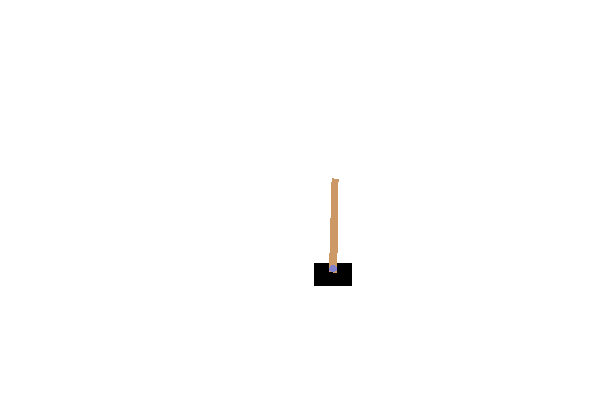
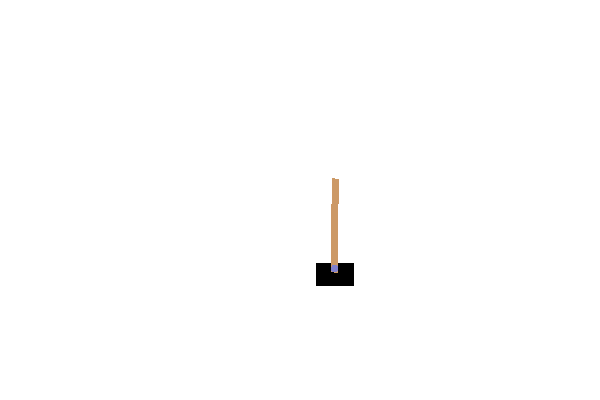
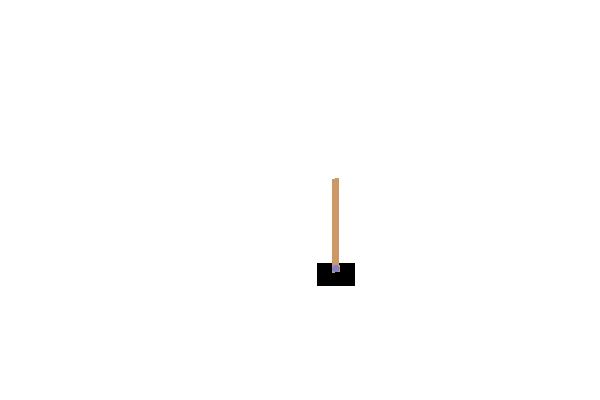
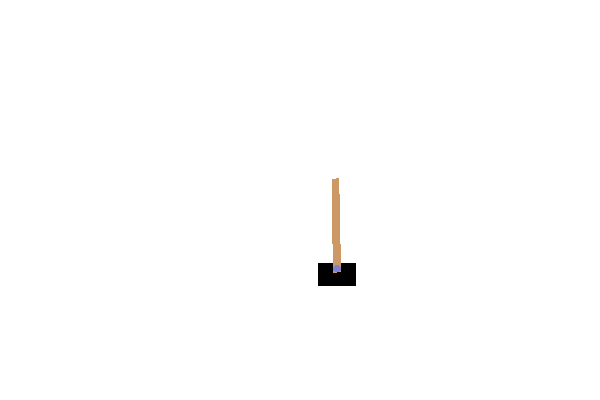
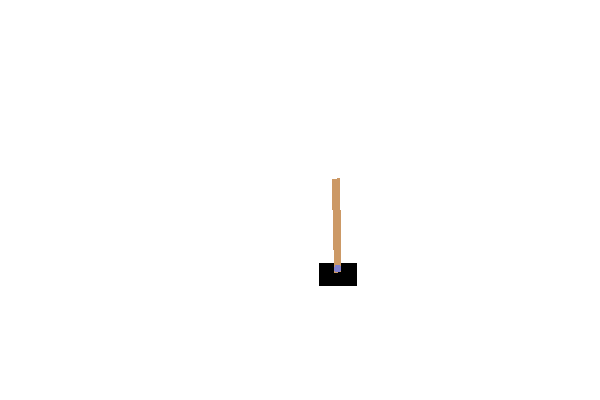
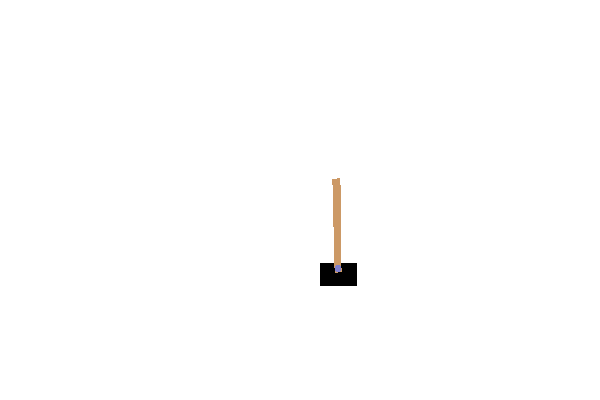
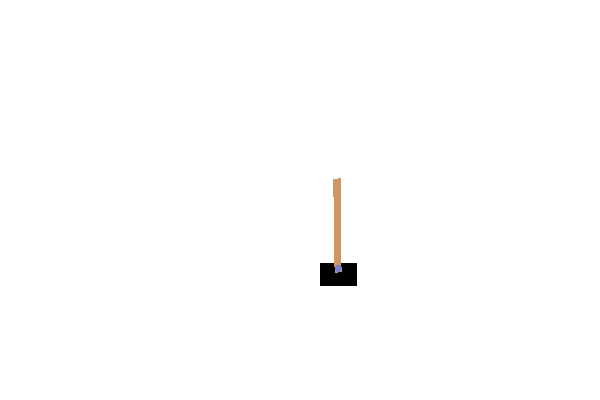
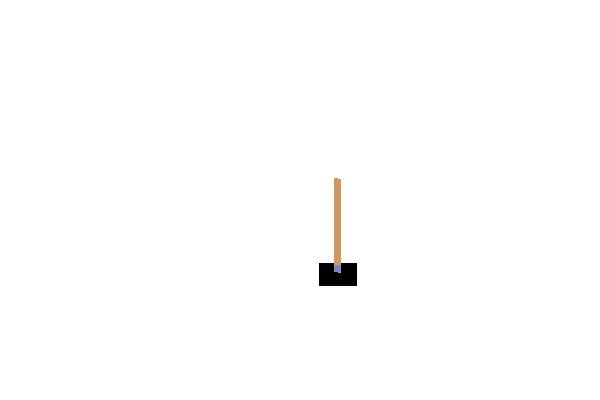
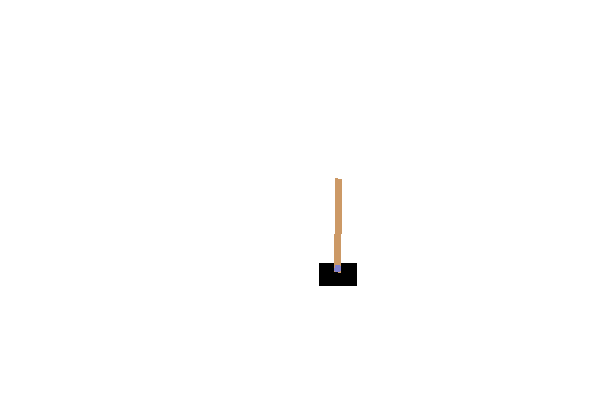
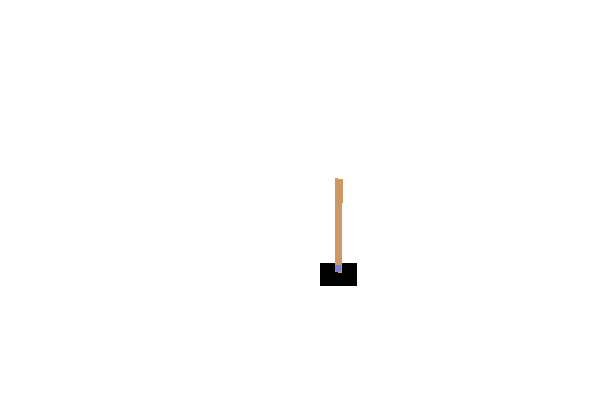
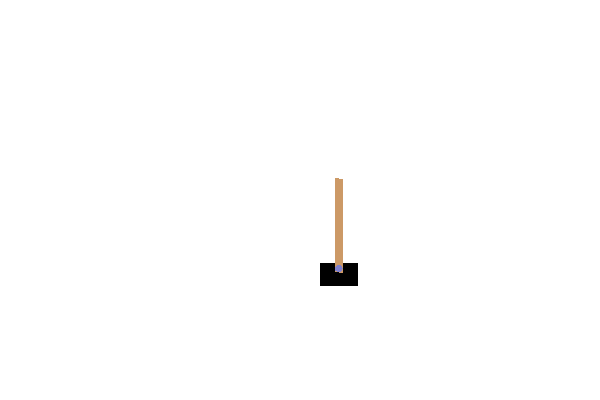
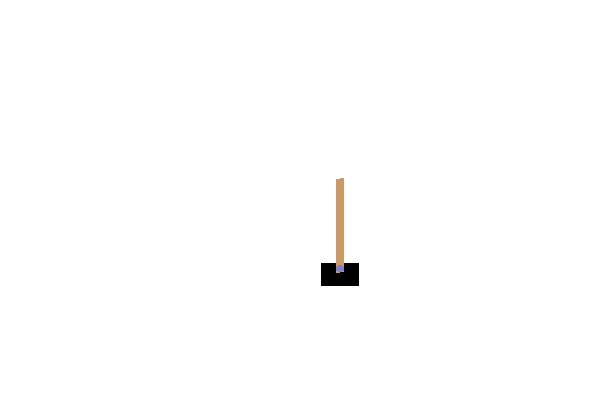
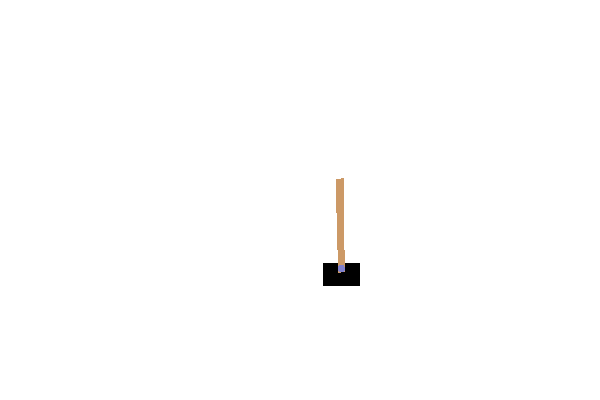
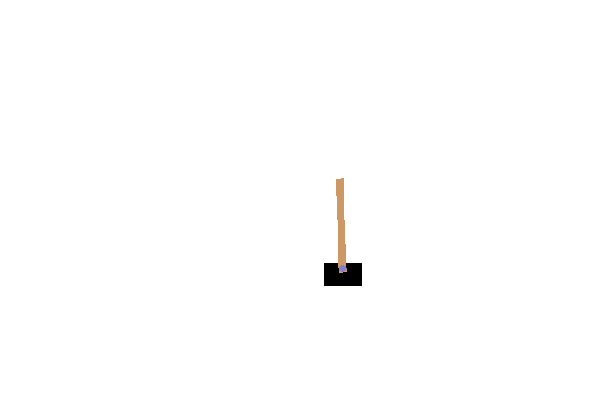
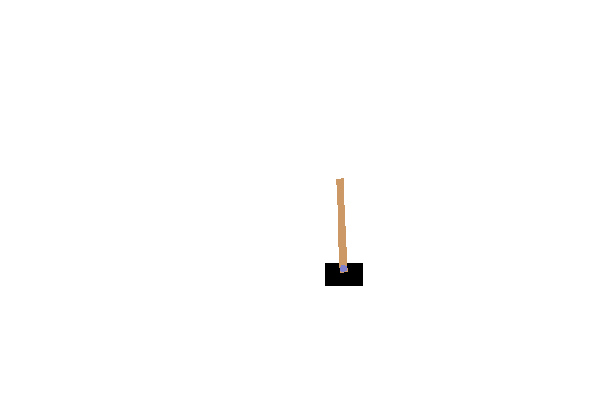
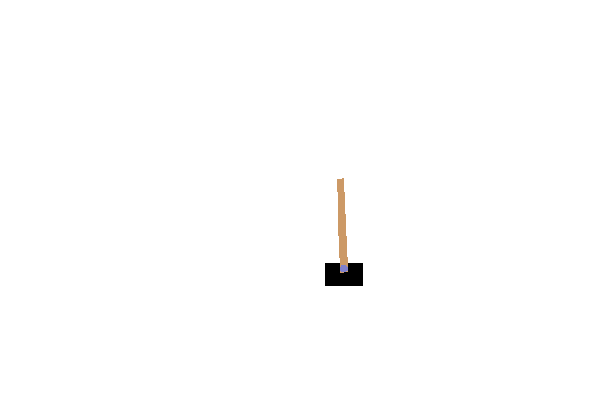
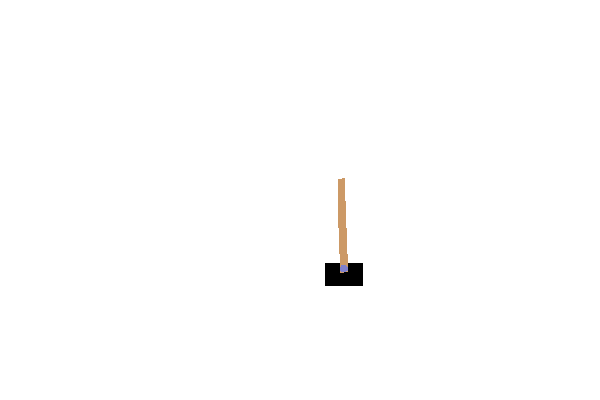
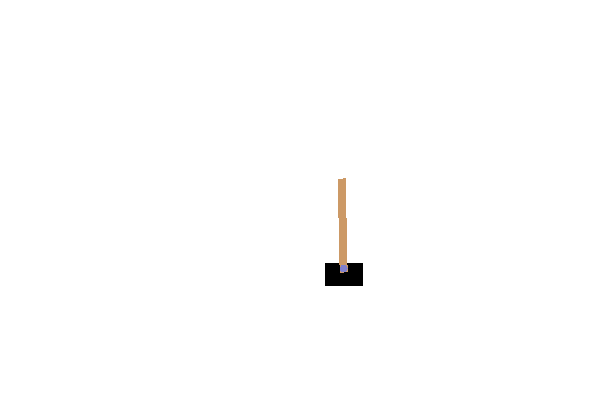
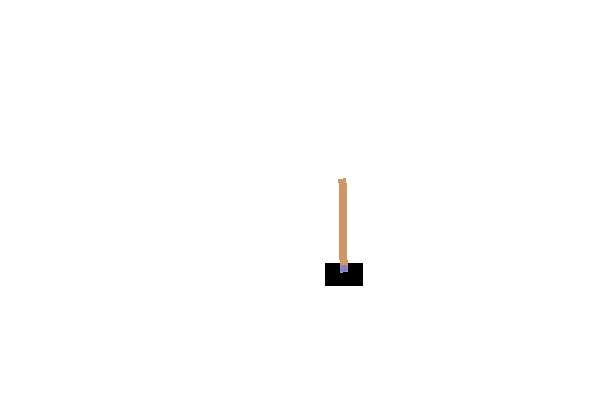
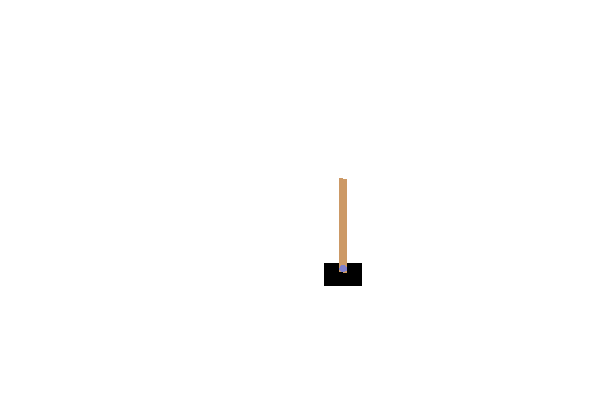
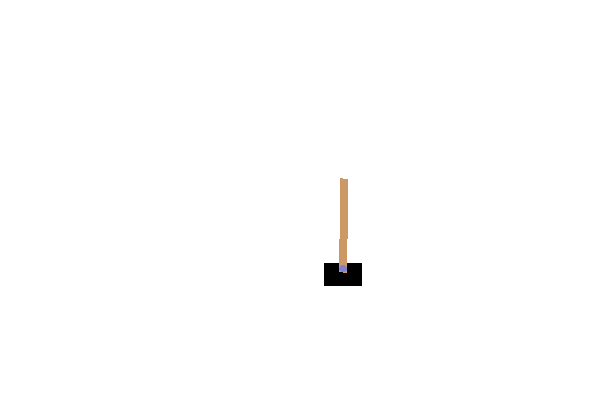
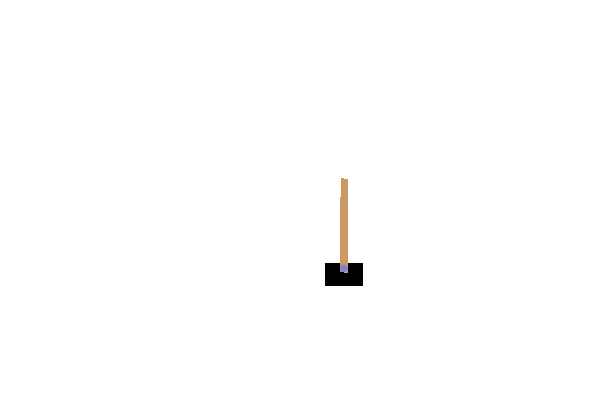
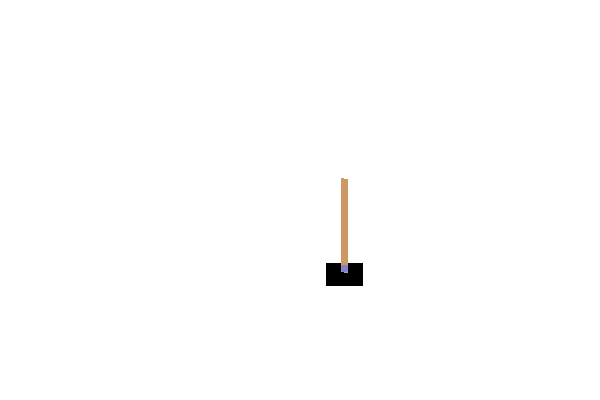
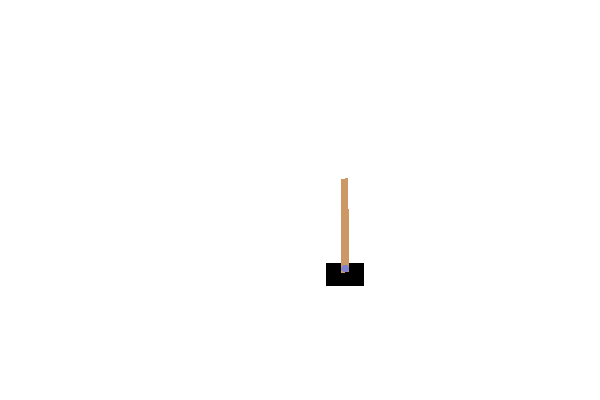
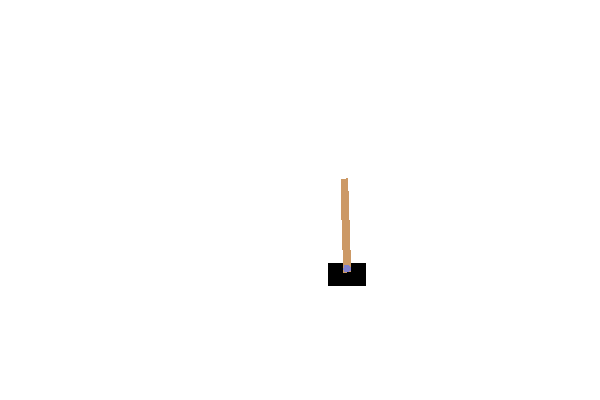
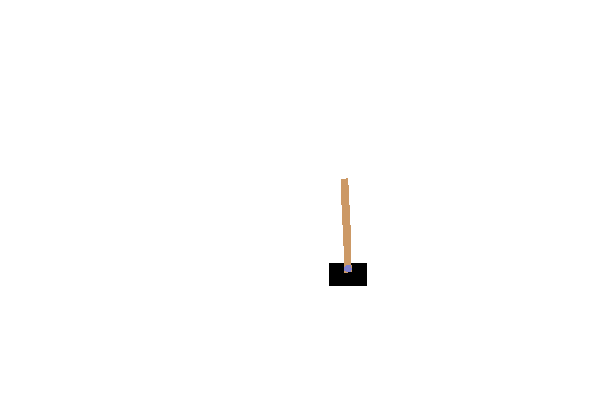
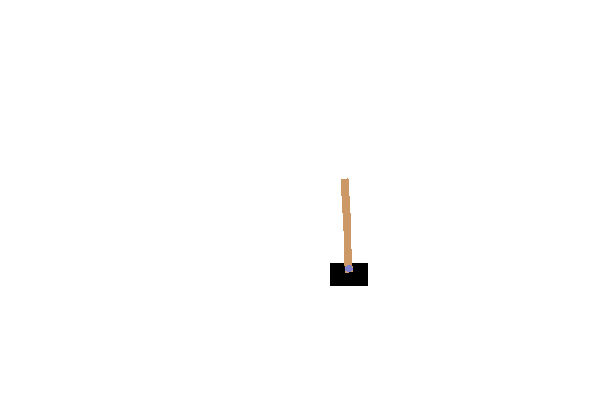
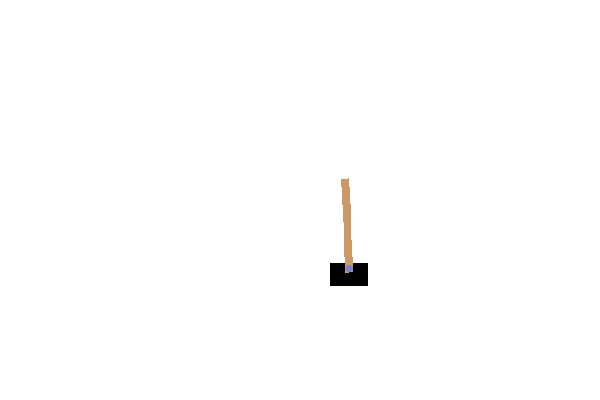
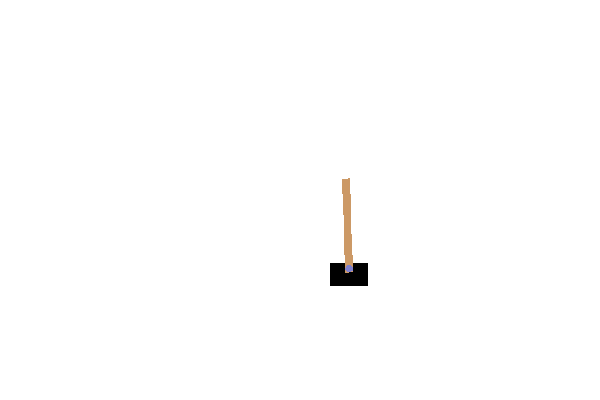
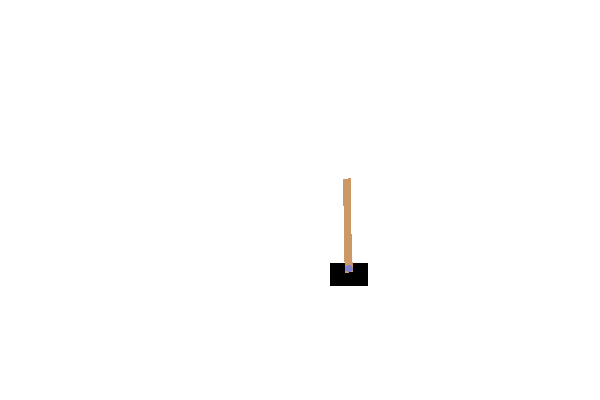
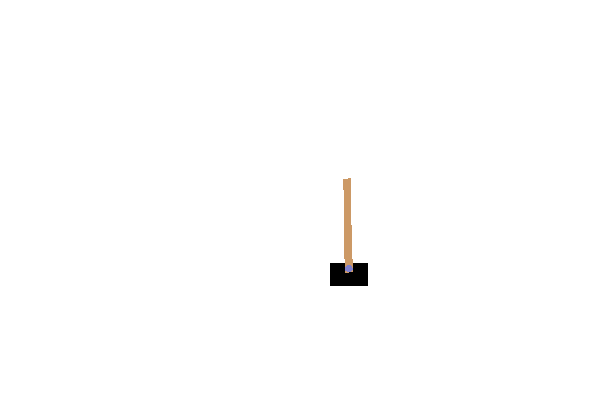
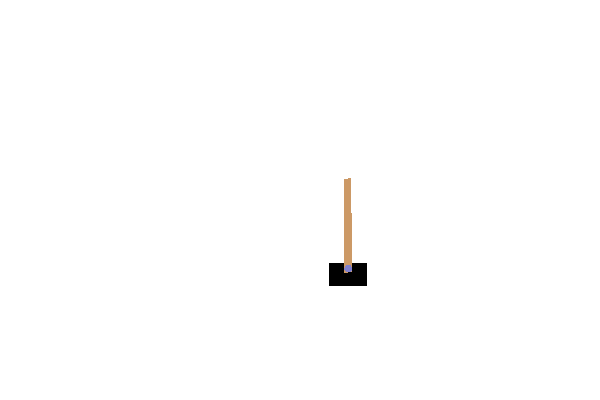
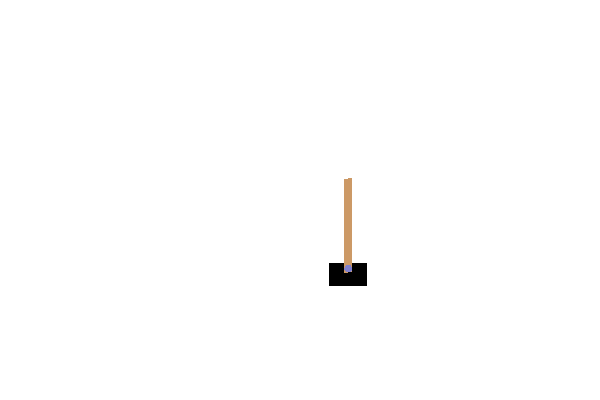
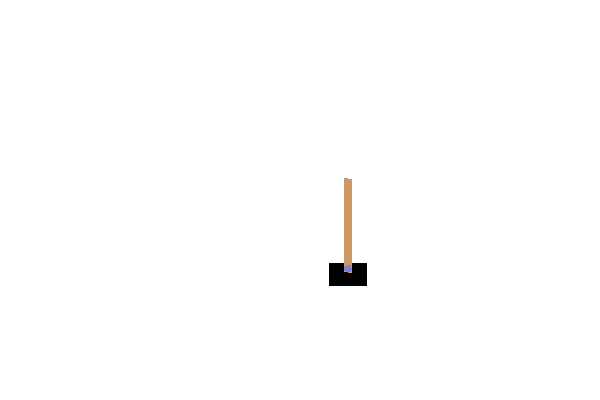
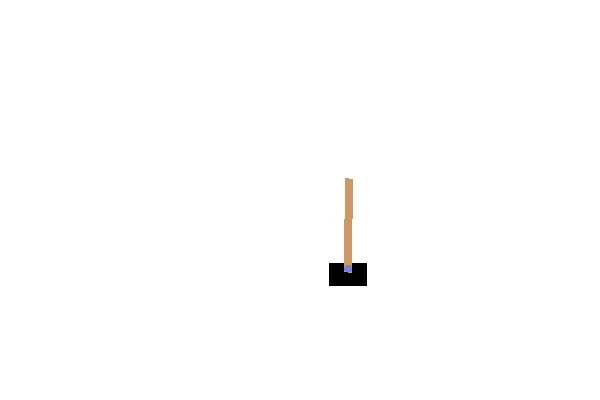
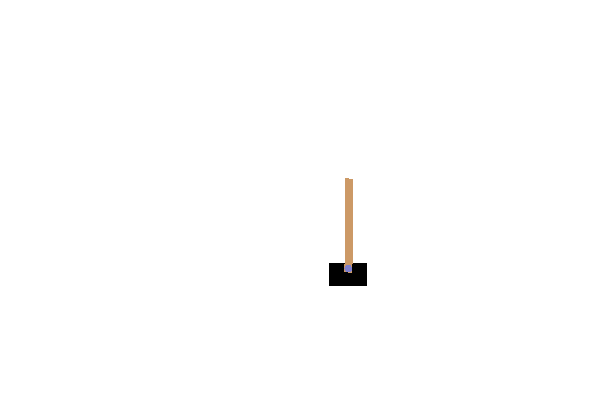
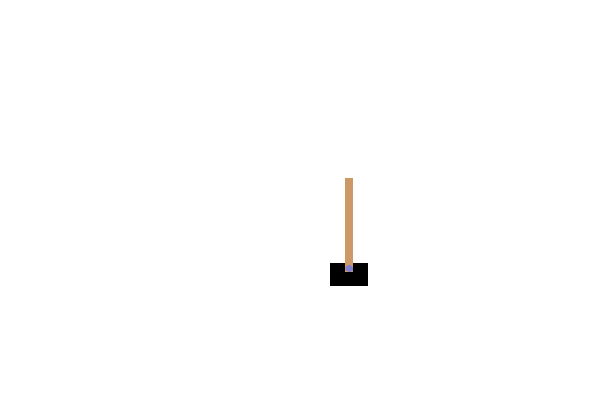
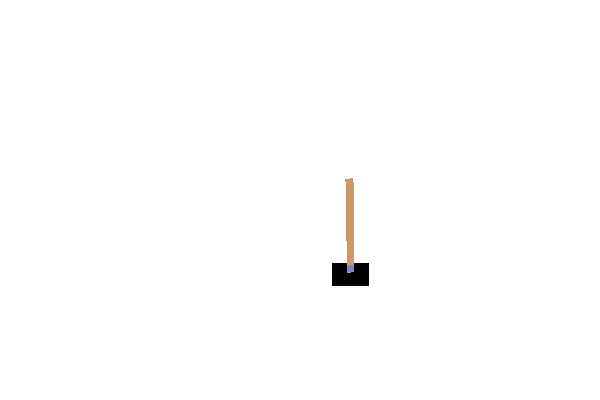
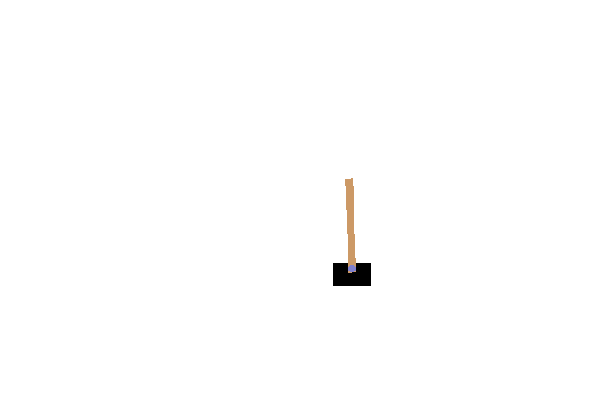
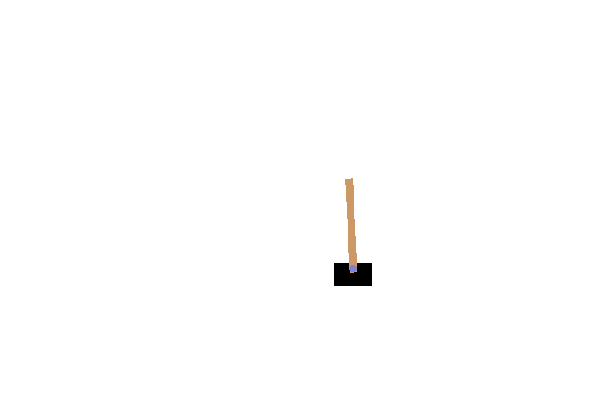
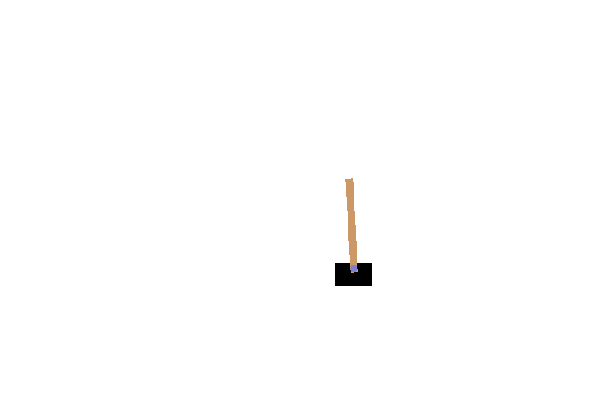
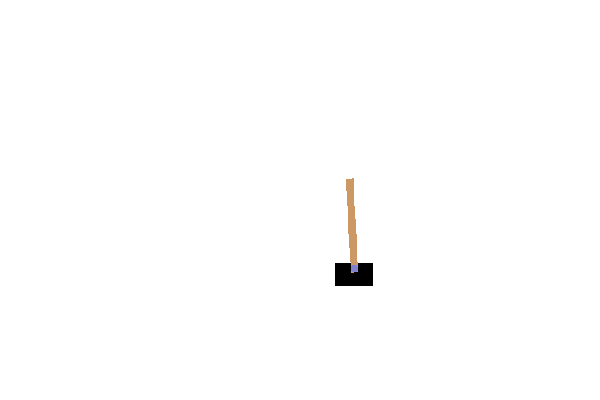
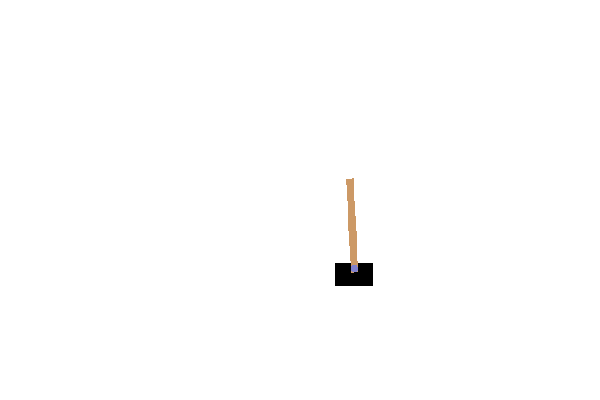
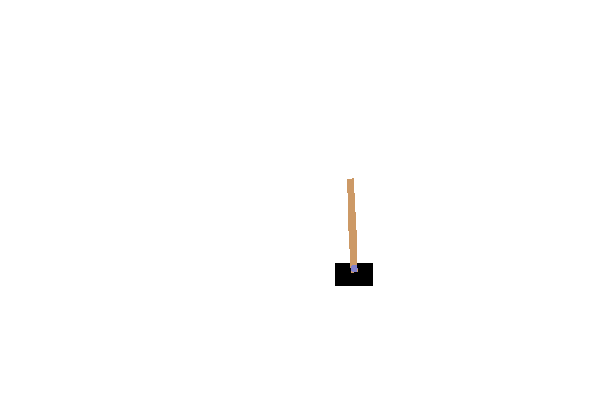
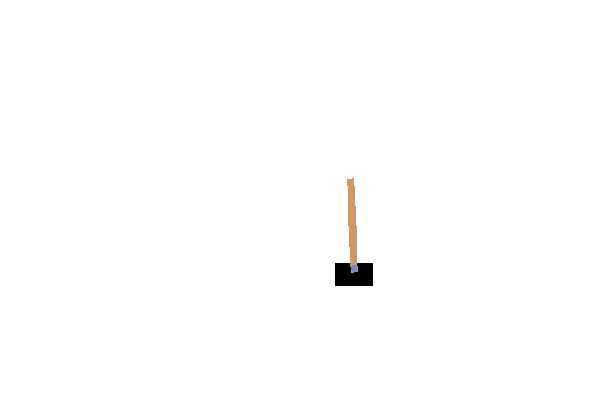
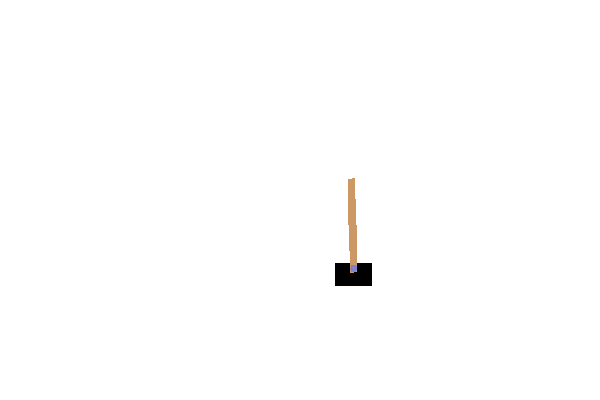
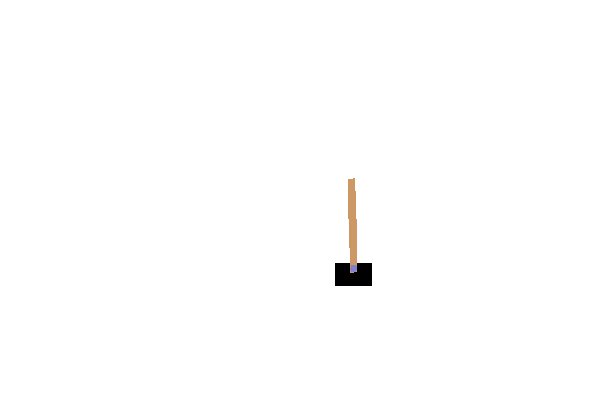
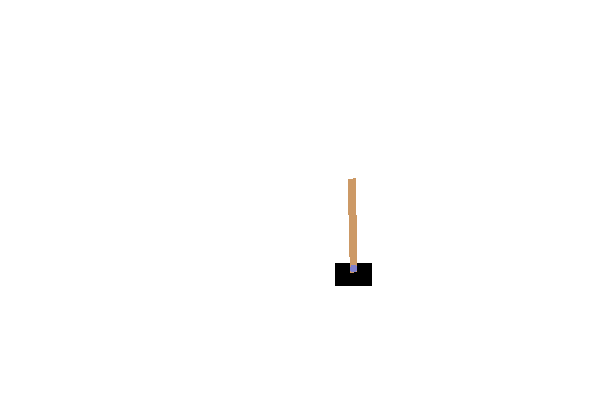
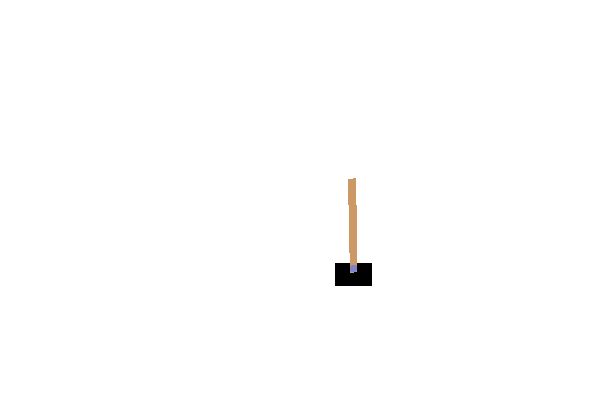
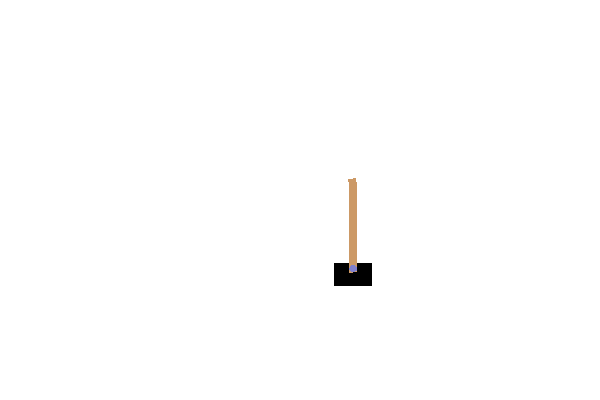
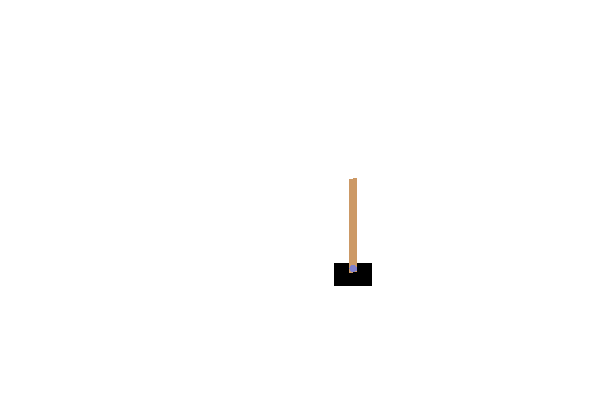

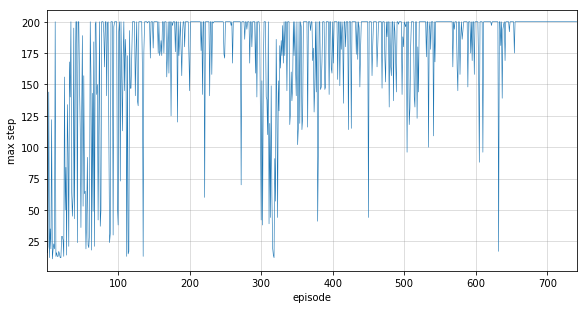

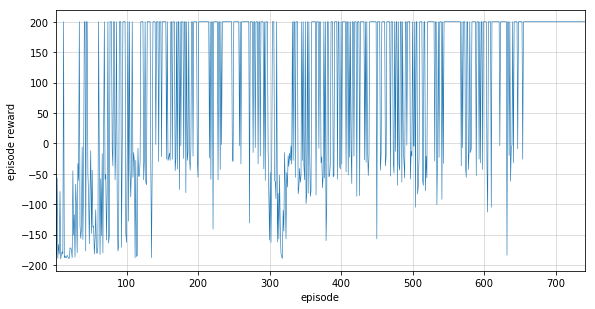

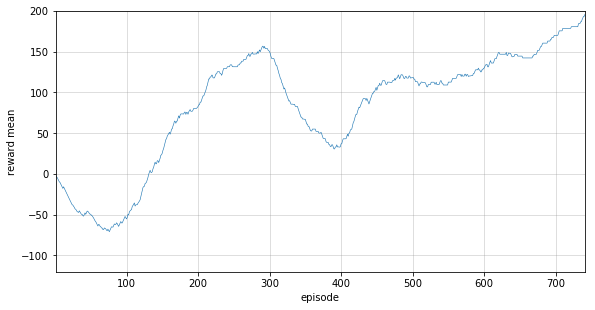

In [7]:
# main
cartpole_env = Environment()
cartpole_env.run()